# Variational Autoencoder (VAE) from Scratch + ELBO Diagnostics

**Convolutional VAE on MNIST with Conditional Extension**

---

## Table of Contents

1. [Part I: Mathematical Foundations](#part1)
   - 1.1 The Problem of Intractable Posteriors
   - 1.2 Evidence Lower Bound (ELBO) Derivation
   - 1.3 The Reparameterization Trick
   - 1.4 VAE Loss Function Interpretation

2. [Part II: Implementation](#part2)
   - 2.1 Convolutional VAE Architecture
   - 2.2 Training with KL Annealing
   - 2.3 Diagnostics: KL vs Reconstruction

3. [Part III: Visualizations](#part3)
   - 3.1 Latent Space Visualization
   - 3.2 Latent Traversals
   - 3.3 Interpolations

4. [Part IV: Extension - Conditional VAE (CVAE)](#part4)
   - 4.1 CVAE Mathematical Derivation
   - 4.2 CVAE Implementation
   - 4.3 Class-Conditional Generation

---

**References:**
- Kingma, D.P. & Welling, M. (2013). *Auto-Encoding Variational Bayes*. [arXiv:1312.6114](https://arxiv.org/abs/1312.6114)
- Doersch, C. (2016). *Tutorial on Variational Autoencoders*. [arXiv:1606.05908](https://arxiv.org/abs/1606.05908)

<a id='part1'></a>
# Part I: Mathematical Foundations

## 1.1 The Problem of Intractable Posteriors

We want to learn a generative model $p_\theta(x)$ of data $x$ (e.g., images). A natural approach is to introduce latent variables $z$ that capture the underlying factors of variation:

$$p_\theta(x) = \int p_\theta(x|z) p(z) \, dz$$

where:
- $p(z)$ is the **prior** over latent variables (typically $\mathcal{N}(0, I)$)
- $p_\theta(x|z)$ is the **decoder/likelihood** (neural network)

### The Intractability Problem

For learning, we need the **posterior** $p_\theta(z|x)$ via Bayes' rule:

$$p_\theta(z|x) = \frac{p_\theta(x|z) p(z)}{p_\theta(x)} = \frac{p_\theta(x|z) p(z)}{\int p_\theta(x|z) p(z) \, dz}$$

This integral is **intractable** for complex decoders (neural networks) because:
1. The integral has no closed form
2. Monte Carlo estimation has exponentially high variance in high dimensions

> *"The true posterior $p_\theta(z|x)$ is intractable... and so is the marginal likelihood $p_\theta(x)$"* — Kingma & Welling (2013), Section 2.2

## 1.2 Evidence Lower Bound (ELBO) Derivation

### The Variational Approach

Since $p_\theta(z|x)$ is intractable, we introduce an **approximate posterior** $q_\phi(z|x)$ (the encoder) and optimize it to be close to the true posterior.

### Derivation Method 1: From KL Divergence

We measure the gap between $q_\phi(z|x)$ and $p_\theta(z|x)$ using KL divergence:

$$D_{KL}(q_\phi(z|x) \| p_\theta(z|x)) = \mathbb{E}_{q_\phi(z|x)}\left[\log \frac{q_\phi(z|x)}{p_\theta(z|x)}\right]$$

Substituting Bayes' rule $p_\theta(z|x) = \frac{p_\theta(x|z)p(z)}{p_\theta(x)}$:

$$D_{KL}(q_\phi(z|x) \| p_\theta(z|x)) = \mathbb{E}_{q_\phi(z|x)}\left[\log \frac{q_\phi(z|x) \cdot p_\theta(x)}{p_\theta(x|z)p(z)}\right]$$

$$= \mathbb{E}_{q_\phi(z|x)}\left[\log q_\phi(z|x) - \log p_\theta(x|z) - \log p(z) + \log p_\theta(x)\right]$$

Since $\log p_\theta(x)$ doesn't depend on $z$:

$$= \log p_\theta(x) + \mathbb{E}_{q_\phi(z|x)}\left[\log q_\phi(z|x) - \log p(z)\right] - \mathbb{E}_{q_\phi(z|x)}\left[\log p_\theta(x|z)\right]$$

$$= \log p_\theta(x) + D_{KL}(q_\phi(z|x) \| p(z)) - \mathbb{E}_{q_\phi(z|x)}\left[\log p_\theta(x|z)\right]$$

Rearranging:

$$\boxed{\log p_\theta(x) = D_{KL}(q_\phi(z|x) \| p_\theta(z|x)) + \underbrace{\mathbb{E}_{q_\phi(z|x)}\left[\log p_\theta(x|z)\right] - D_{KL}(q_\phi(z|x) \| p(z))}_{\mathcal{L}(\theta, \phi; x) = \text{ELBO}}}$$

### The ELBO

Since $D_{KL} \geq 0$, we have:

$$\log p_\theta(x) \geq \mathcal{L}(\theta, \phi; x) = \underbrace{\mathbb{E}_{q_\phi(z|x)}\left[\log p_\theta(x|z)\right]}_{\text{Reconstruction term}} - \underbrace{D_{KL}(q_\phi(z|x) \| p(z))}_{\text{Regularization term}}$$

This is the **Evidence Lower BOund** (ELBO). Maximizing the ELBO:
1. Maximizes a lower bound on the log-likelihood $\log p_\theta(x)$
2. Minimizes $D_{KL}(q_\phi(z|x) \| p_\theta(z|x))$ — making our encoder approximate the true posterior

> *"We can optimize the lower bound $\mathcal{L}(\theta, \phi; x)$ w.r.t. both the variational parameters $\phi$ and generative parameters $\theta$"* — Kingma & Welling (2013), Section 2.2

### Interpretation of ELBO Terms

**Reconstruction Term:** $\mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)]$
- Measures how well we can reconstruct $x$ from a sampled $z$
- Encourages the decoder to produce outputs close to the input

**KL Regularization Term:** $D_{KL}(q_\phi(z|x) \| p(z))$
- Measures how close the encoder distribution is to the prior
- Encourages the latent space to be well-structured

### Tension Between Terms

There is an inherent **trade-off**:

- **High reconstruction, low KL**: The encoder can encode very specific information about $x$ into $z$, but the latent space becomes irregular (poor generation)
- **Low reconstruction, high KL**: The latent space is well-regularized but doesn't encode enough information (blurry reconstructions)

This phenomenon is called **posterior collapse** when the KL term dominates, or **overfitting** when reconstruction dominates.

> *"We can view the KL term as regularizing $\phi$, encouraging the approximate posterior to be close to the prior"* — Doersch (2016), Section 2.4

## 1.3 The Reparameterization Trick

### The Problem with Sampling

To compute the reconstruction term, we need:

$$\mathbb{E}_{q_\phi(z|x)}\left[\log p_\theta(x|z)\right] \approx \frac{1}{L}\sum_{l=1}^{L} \log p_\theta(x|z^{(l)}) \quad \text{where } z^{(l)} \sim q_\phi(z|x)$$

**Problem**: Sampling $z \sim q_\phi(z|x)$ is a **stochastic operation** that blocks gradient flow!

$$\frac{\partial}{\partial \phi} \mathbb{E}_{q_\phi(z|x)}[f(z)] = \; ?$$

We cannot backpropagate through random sampling.

### The Solution: Reparameterization

For $q_\phi(z|x) = \mathcal{N}(\mu_\phi(x), \sigma^2_\phi(x))$, we can write:

$$z = \mu_\phi(x) + \sigma_\phi(x) \odot \epsilon \quad \text{where } \epsilon \sim \mathcal{N}(0, I)$$

Now the randomness is in $\epsilon$, which doesn't depend on $\phi$!

$$\frac{\partial}{\partial \phi} \mathbb{E}_{\epsilon \sim \mathcal{N}(0,I)}[f(\mu_\phi(x) + \sigma_\phi(x) \odot \epsilon)] = \mathbb{E}_{\epsilon}\left[\frac{\partial f}{\partial z} \cdot \frac{\partial z}{\partial \phi}\right]$$

This allows gradients to flow through the sampling operation!

> *"We can now form Monte Carlo estimates of expectations of some function $f(z)$ w.r.t. $q_\phi(z|x)$ that are differentiable w.r.t. $\phi$"* — Kingma & Welling (2013), Section 2.4

### Visual Representation

**WITHOUT Reparameterization** | **WITH Reparameterization** |
|:---:|:---:|
$x$ | $x$ |
$\downarrow$ | $\downarrow$ |
Encoder | Encoder |
$\downarrow$ | $\swarrow \quad \searrow$ |
$\mu, \sigma$ | $\mu \qquad \sigma$ |
$\downarrow$ | $\downarrow \qquad \downarrow$ |
$z \sim \mathcal{N}(\mu,\sigma^2)$  | $z = \mu + \sigma \odot \epsilon$  |
$\downarrow$ | $\uparrow$ |
Decoder | $\epsilon \sim \mathcal{N}(0,I)$ |
$\downarrow$ | |
$\hat{x}$ | |

The key insight: by moving the stochasticity to $\epsilon$ (which doesn't depend on $\phi$), gradients can flow through $\mu$ and $\sigma$.

## 1.4 Closed-Form KL for Gaussians

When both $q_\phi(z|x)$ and $p(z)$ are Gaussian, the KL divergence has a **closed form**.

For $q_\phi(z|x) = \mathcal{N}(\mu, \text{diag}(\sigma^2))$ and $p(z) = \mathcal{N}(0, I)$:

$$D_{KL}(q_\phi(z|x) \| p(z)) = -\frac{1}{2}\sum_{j=1}^{J}\left(1 + \log\sigma_j^2 - \mu_j^2 - \sigma_j^2\right)$$

where $J$ is the latent dimension.

### Derivation

$$D_{KL} = \int q(z) \log\frac{q(z)}{p(z)} dz = \mathbb{E}_q[\log q(z)] - \mathbb{E}_q[\log p(z)]$$

For diagonal Gaussian $q(z) = \mathcal{N}(\mu, \text{diag}(\sigma^2))$:
$$\mathbb{E}_q[\log q(z)] = -\frac{J}{2}\log(2\pi) - \frac{1}{2}\sum_j \log\sigma_j^2 - \frac{J}{2}$$

For standard Gaussian $p(z) = \mathcal{N}(0, I)$:
$$\mathbb{E}_q[\log p(z)] = -\frac{J}{2}\log(2\pi) - \frac{1}{2}\sum_j (\mu_j^2 + \sigma_j^2)$$

Subtracting:
$$D_{KL} = -\frac{1}{2}\sum_j \log\sigma_j^2 - \frac{J}{2} + \frac{1}{2}\sum_j (\mu_j^2 + \sigma_j^2) = -\frac{1}{2}\sum_j(1 + \log\sigma_j^2 - \mu_j^2 - \sigma_j^2)$$

> *"This KL-divergence can be computed and differentiated without estimation"* — Kingma & Welling (2013), Appendix B

### Gradients of the KL Term

For optimization, we need the gradients with respect to the encoder parameters. Since the encoder outputs $\mu_j$ and $\log\sigma_j^2$ (we use log-variance for numerical stability), we compute:

**Gradient w.r.t. $\mu_j$:**
$$\frac{\partial D_{KL}}{\partial \mu_j} = \mu_j$$

**Gradient w.r.t. $\log\sigma_j^2$:**

Let $v_j = \log\sigma_j^2$, so $\sigma_j^2 = e^{v_j}$. Then:
$$D_{KL} = -\frac{1}{2}\sum_j(1 + v_j - \mu_j^2 - e^{v_j})$$

$$\frac{\partial D_{KL}}{\partial v_j} = -\frac{1}{2}(1 - e^{v_j}) = \frac{1}{2}(\sigma_j^2 - 1)$$

These simple gradients allow efficient backpropagation through the KL term.

## 1.5 Final VAE Loss Function

Putting it all together, the **VAE loss** (negative ELBO) to minimize is:

$$\mathcal{L}_{VAE} = -\mathbb{E}_{\epsilon \sim \mathcal{N}(0,I)}\left[\log p_\theta(x|z)\right] + D_{KL}(q_\phi(z|x) \| p(z))$$

where $z = \mu_\phi(x) + \sigma_\phi(x) \odot \epsilon$.

### For Binary Data (MNIST)

With Bernoulli decoder $p_\theta(x|z) = \text{Bernoulli}(\hat{x})$:

$$\mathcal{L}_{VAE} = \underbrace{\text{BCE}(x, \hat{x})}_{\text{Reconstruction}} + \underbrace{\frac{1}{2}\sum_j(\mu_j^2 + \sigma_j^2 - \log\sigma_j^2 - 1)}_{\text{KL Divergence}}$$

where BCE is Binary Cross-Entropy: $\text{BCE}(x, \hat{x}) = -\sum_i [x_i \log \hat{x}_i + (1-x_i)\log(1-\hat{x}_i)]$

### Gradients Through the Reparameterization

The key innovation is that we can now compute gradients of the reconstruction loss w.r.t. encoder parameters $\phi$.

Given $z = \mu + \sigma \odot \epsilon$ and a loss $\mathcal{L}_{recon}(x, \text{Dec}(z))$:

**Gradient w.r.t. $\mu$:**
$$\frac{\partial \mathcal{L}_{recon}}{\partial \mu} = \frac{\partial \mathcal{L}_{recon}}{\partial z} \cdot \frac{\partial z}{\partial \mu} = \frac{\partial \mathcal{L}_{recon}}{\partial z}$$

**Gradient w.r.t. $\sigma$ (or $\log\sigma^2$):**
$$\frac{\partial \mathcal{L}_{recon}}{\partial \sigma} = \frac{\partial \mathcal{L}_{recon}}{\partial z} \cdot \frac{\partial z}{\partial \sigma} = \frac{\partial \mathcal{L}_{recon}}{\partial z} \odot \epsilon$$

Using $v = \log\sigma^2$:
$$\frac{\partial \mathcal{L}_{recon}}{\partial v} = \frac{\partial \mathcal{L}_{recon}}{\partial z} \odot \epsilon \odot \frac{\sigma}{2}$$

### Complete Gradient for VAE

The total gradient for encoder parameters combines both terms:

$$\nabla_\phi \mathcal{L}_{VAE} = \nabla_\phi \mathcal{L}_{recon} + \nabla_\phi D_{KL}$$

For decoder parameters $\theta$, only the reconstruction term contributes:

$$\nabla_\theta \mathcal{L}_{VAE} = \nabla_\theta \mathcal{L}_{recon}$$

> *"The resulting estimator for the lower bound... exhibits much lower variance than the generic estimator"* — Kingma & Welling (2013), Section 2.4

---
<a id='part2'></a>
# Part II: Implementation

## 2.1 Setup and Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cpu


In [4]:
# Hyperparameters
BATCH_SIZE = 128
LATENT_DIM = 2  # Start with 2D for visualization, can increase later
LEARNING_RATE = 1e-3
EPOCHS = 30

# Load MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 304kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.12MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 635kB/s]

Training samples: 60000
Test samples: 10000


## 2.2 Convolutional VAE Architecture

We implement a convolutional VAE with:
- **Encoder**: Conv layers → Flatten → FC → (μ, log σ²)
- **Decoder**: FC → Reshape → ConvTranspose layers → Sigmoid

In [5]:
class ConvEncoder(nn.Module):
    """Convolutional encoder that maps x -> (mu, log_var)"""

    def __init__(self, latent_dim):
        super().__init__()

        # Convolutional layers
        # Input: (1, 28, 28)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)   # -> (32, 14, 14)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  # -> (64, 7, 7)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1) # -> (128, 4, 4)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        # Flatten size: 128 * 4 * 4 = 2048
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_log_var = nn.Linear(128 * 4 * 4, latent_dim)

    def forward(self, x):
        # Convolutional feature extraction
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        # Flatten
        x = x.view(x.size(0), -1)

        # Output mu and log_var
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)

        return mu, log_var


class ConvDecoder(nn.Module):
    """Convolutional decoder that maps z -> x_reconstructed"""

    def __init__(self, latent_dim):
        super().__init__()

        # FC to reshape
        self.fc = nn.Linear(latent_dim, 128 * 4 * 4)

        # Transposed convolutions
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1)  # -> (64, 7, 7)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)  # -> (32, 14, 14)
        self.deconv3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)   # -> (1, 28, 28)

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(32)

    def forward(self, z):
        # FC and reshape
        x = F.relu(self.fc(z))
        x = x.view(-1, 128, 4, 4)

        # Transposed convolutions
        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = torch.sigmoid(self.deconv3(x))  # Sigmoid for [0, 1] pixel values

        return x

In [6]:
class VAE(nn.Module):
    """Variational Autoencoder combining encoder and decoder"""

    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = ConvEncoder(latent_dim)
        self.decoder = ConvDecoder(latent_dim)

    def reparameterize(self, mu, log_var):
        """
        Reparameterization trick: z = mu + sigma * epsilon
        where epsilon ~ N(0, I)
        """
        std = torch.exp(0.5 * log_var)  # sigma = exp(0.5 * log(sigma^2))
        epsilon = torch.randn_like(std)  # Sample from N(0, I)
        z = mu + std * epsilon
        return z

    def forward(self, x):
        # Encode
        mu, log_var = self.encoder(x)

        # Reparameterize
        z = self.reparameterize(mu, log_var)

        # Decode
        x_recon = self.decoder(z)

        return x_recon, mu, log_var, z

    def sample(self, num_samples):
        """Generate samples by sampling z ~ p(z) and decoding"""
        z = torch.randn(num_samples, self.latent_dim).to(next(self.parameters()).device)
        samples = self.decoder(z)
        return samples


# Test the architecture
model = VAE(LATENT_DIM).to(device)
test_input = torch.randn(2, 1, 28, 28).to(device)
x_recon, mu, log_var, z = model(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Reconstructed shape: {x_recon.shape}")
print(f"Latent (mu) shape: {mu.shape}")
print(f"Latent (z) shape: {z.shape}")

Input shape: torch.Size([2, 1, 28, 28])
Reconstructed shape: torch.Size([2, 1, 28, 28])
Latent (mu) shape: torch.Size([2, 2])
Latent (z) shape: torch.Size([2, 2])


## 2.3 Loss Function and KL Annealing

### KL Annealing

KL annealing is a training strategy where we gradually increase the weight of the KL term:

$$\mathcal{L} = \mathcal{L}_{recon} + \alpha(t) \cdot \mathcal{L}_{KL}$$

where $\alpha(t)$ increases from 0 to 1 during training.

**Why?** Early in training:
- With full KL weight, the model may collapse to $q(z|x) \approx p(z)$ (posterior collapse)
- By starting with low KL weight, the encoder first learns to encode useful information
- Then we gradually enforce the prior constraint

> *"KL cost annealing... gradually turning on the KL term from 0 to 1 over a number of epochs"* — Bowman et al., 2016

In [7]:
def vae_loss(x, x_recon, mu, log_var, kl_weight=1.0):
    """
    Compute VAE loss = Reconstruction + KL Divergence

    Args:
        x: Original input (batch_size, 1, 28, 28)
        x_recon: Reconstructed output (batch_size, 1, 28, 28)
        mu: Mean of latent distribution (batch_size, latent_dim)
        log_var: Log variance of latent distribution (batch_size, latent_dim)
        kl_weight: Weight for KL term (for annealing)

    Returns:
        total_loss, recon_loss, kl_loss (all averaged over batch)
    """
    # Reconstruction loss: Binary Cross-Entropy (sum over pixels, mean over batch)
    # Using reduction='none' to sum over pixels, then mean over batch
    recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum') / x.size(0)

    # KL Divergence: -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # Sum over latent dimensions, mean over batch
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1).mean()

    # Total loss with KL weight
    total_loss = recon_loss + kl_weight * kl_loss

    return total_loss, recon_loss, kl_loss


def get_kl_weight(epoch, warmup_epochs=10, annealing_type='linear'):
    """
    Compute KL weight for annealing

    Args:
        epoch: Current epoch (0-indexed)
        warmup_epochs: Number of epochs for warmup
        annealing_type: 'linear' or 'sigmoid'
    """
    if annealing_type == 'linear':
        return min(1.0, epoch / warmup_epochs)
    elif annealing_type == 'sigmoid':
        # Sigmoid centered at warmup_epochs/2
        return 1.0 / (1.0 + np.exp(-0.5 * (epoch - warmup_epochs / 2)))
    else:
        return 1.0  # No annealing

## 2.4 Training Loop with Diagnostics

In [6]:
def train_vae(model, train_loader, test_loader, epochs, lr, warmup_epochs=10, annealing_type='linear'):
    """
    Train VAE with KL annealing and track diagnostics
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Tracking metrics
    history = {
        'train_loss': [], 'train_recon': [], 'train_kl': [],
        'test_loss': [], 'test_recon': [], 'test_kl': [],
        'kl_weight': []
    }

    for epoch in range(epochs):
        # Get KL weight for this epoch
        kl_weight = get_kl_weight(epoch, warmup_epochs, annealing_type)
        history['kl_weight'].append(kl_weight)

        # Training
        model.train()
        train_loss, train_recon, train_kl = 0, 0, 0

        for x, _ in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False):
            x = x.to(device)

            optimizer.zero_grad()
            x_recon, mu, log_var, z = model(x)
            loss, recon, kl = vae_loss(x, x_recon, mu, log_var, kl_weight)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_recon += recon.item()
            train_kl += kl.item()

        # Average over batches
        n_batches = len(train_loader)
        history['train_loss'].append(train_loss / n_batches)
        history['train_recon'].append(train_recon / n_batches)
        history['train_kl'].append(train_kl / n_batches)

        # Evaluation
        model.eval()
        test_loss, test_recon, test_kl = 0, 0, 0

        with torch.no_grad():
            for x, _ in test_loader:
                x = x.to(device)
                x_recon, mu, log_var, z = model(x)
                loss, recon, kl = vae_loss(x, x_recon, mu, log_var, kl_weight=1.0)  # Full weight for eval

                test_loss += loss.item()
                test_recon += recon.item()
                test_kl += kl.item()

        n_batches = len(test_loader)
        history['test_loss'].append(test_loss / n_batches)
        history['test_recon'].append(test_recon / n_batches)
        history['test_kl'].append(test_kl / n_batches)

        # Print progress
        print(f"Epoch {epoch+1:2d} | KL_w: {kl_weight:.3f} | "
              f"Train: L={history['train_loss'][-1]:.1f} R={history['train_recon'][-1]:.1f} KL={history['train_kl'][-1]:.1f} | "
              f"Test: L={history['test_loss'][-1]:.1f} R={history['test_recon'][-1]:.1f} KL={history['test_kl'][-1]:.1f}")

    return history

In [7]:
# Train the VAE
model = VAE(LATENT_DIM).to(device)
history = train_vae(model, train_loader, test_loader,
                    epochs=EPOCHS, lr=LEARNING_RATE,
                    warmup_epochs=10, annealing_type='linear')

Epoch  1 | KL_w: 0.000 | Train: L=210.0 R=210.0 KL=737.4 | Test: L=192.3 R=162.0 KL=30.3


Epoch  2 | KL_w: 0.100 | Train: L=159.6 R=158.3 KL=13.4 | Test: L=165.7 R=154.0 KL=11.7


Epoch  3 | KL_w: 0.200 | Train: L=154.5 R=152.6 KL=9.7 | Test: L=158.6 R=149.5 KL=9.1


Epoch  4 | KL_w: 0.300 | Train: L=152.3 R=149.7 KL=8.6 | Test: L=156.2 R=147.5 KL=8.7


Epoch  5 | KL_w: 0.400 | Train: L=150.7 R=147.5 KL=8.0 | Test: L=155.3 R=147.1 KL=8.2


Epoch  6 | KL_w: 0.500 | Train: L=149.9 R=146.1 KL=7.5 | Test: L=152.3 R=144.9 KL=7.4


Epoch  7 | KL_w: 0.600 | Train: L=149.2 R=144.9 KL=7.2 | Test: L=151.1 R=144.1 KL=7.0


Epoch  8 | KL_w: 0.700 | Train: L=149.0 R=144.1 KL=6.9 | Test: L=150.0 R=143.1 KL=6.8


Epoch  9 | KL_w: 0.800 | Train: L=148.7 R=143.3 KL=6.7 | Test: L=150.1 R=143.6 KL=6.5


Epoch 10 | KL_w: 0.900 | Train: L=148.6 R=142.7 KL=6.6 | Test: L=148.4 R=141.7 KL=6.6


Epoch 11 | KL_w: 1.000 | Train: L=148.4 R=142.0 KL=6.5 | Test: L=148.6 R=142.0 KL=6.6


Epoch 12 | KL_w: 1.000 | Train: L=147.9 R=141.4 KL=6.4 | Test: L=150.1 R=143.8 KL=6.3


Epoch 13 | KL_w: 1.000 | Train: L=147.4 R=141.0 KL=6.4 | Test: L=148.0 R=141.6 KL=6.4


Epoch 14 | KL_w: 1.000 | Train: L=146.8 R=140.4 KL=6.4 | Test: L=147.3 R=141.0 KL=6.3


Epoch 15 | KL_w: 1.000 | Train: L=146.5 R=140.0 KL=6.4 | Test: L=147.6 R=141.2 KL=6.4


Epoch 16 | KL_w: 1.000 | Train: L=146.1 R=139.7 KL=6.4 | Test: L=147.3 R=140.9 KL=6.5


Epoch 17 | KL_w: 1.000 | Train: L=145.7 R=139.2 KL=6.5 | Test: L=146.4 R=139.8 KL=6.6


Epoch 18 | KL_w: 1.000 | Train: L=145.4 R=139.0 KL=6.5 | Test: L=146.3 R=139.8 KL=6.5


Epoch 19 | KL_w: 1.000 | Train: L=145.1 R=138.7 KL=6.5 | Test: L=146.2 R=139.7 KL=6.5


Epoch 20 | KL_w: 1.000 | Train: L=144.8 R=138.3 KL=6.5 | Test: L=146.6 R=140.2 KL=6.3


Epoch 21 | KL_w: 1.000 | Train: L=144.5 R=138.0 KL=6.5 | Test: L=146.5 R=140.0 KL=6.5


Epoch 22 | KL_w: 1.000 | Train: L=144.2 R=137.7 KL=6.5 | Test: L=146.2 R=139.9 KL=6.3


Epoch 23 | KL_w: 1.000 | Train: L=144.1 R=137.5 KL=6.5 | Test: L=145.8 R=139.3 KL=6.5


Epoch 24 | KL_w: 1.000 | Train: L=143.8 R=137.3 KL=6.5 | Test: L=145.5 R=139.0 KL=6.4


Epoch 25 | KL_w: 1.000 | Train: L=143.6 R=137.0 KL=6.5 | Test: L=145.2 R=138.7 KL=6.6


Epoch 26 | KL_w: 1.000 | Train: L=143.4 R=136.8 KL=6.6 | Test: L=145.4 R=138.9 KL=6.5


Epoch 27 | KL_w: 1.000 | Train: L=143.2 R=136.6 KL=6.6 | Test: L=145.3 R=138.7 KL=6.6


Epoch 28 | KL_w: 1.000 | Train: L=143.0 R=136.4 KL=6.6 | Test: L=145.2 R=138.7 KL=6.5


Epoch 29 | KL_w: 1.000 | Train: L=142.8 R=136.2 KL=6.6 | Test: L=145.8 R=139.1 KL=6.7


Epoch 30 | KL_w: 1.000 | Train: L=142.6 R=136.0 KL=6.6 | Test: L=145.0 R=138.3 KL=6.7


In [8]:
# Save VAE model locally
import os

# Create models directory
os.makedirs('models', exist_ok=True)

# Save model state dict and training history
torch.save({
    'model_state_dict': model.state_dict(),
    'history': history,
    'latent_dim': LATENT_DIM,
    'epochs': EPOCHS
}, 'models/vae_mnist.pth')

print("VAE model saved to 'models/vae_mnist.pth'")


VAE model saved to 'models/vae_mnist.pth'


## 2.5 Diagnostics: KL vs Reconstruction Analysis

Analyzing the behavior of KL and reconstruction terms reveals important phenomena:

1. **Under-regularization** (high recon, low KL): Latent space is irregular, poor generation
2. **Over-regularization** (low recon, high KL): Posterior collapse, blurry reconstructions
3. **Balanced**: Good trade-off between reconstruction quality and latent space structure

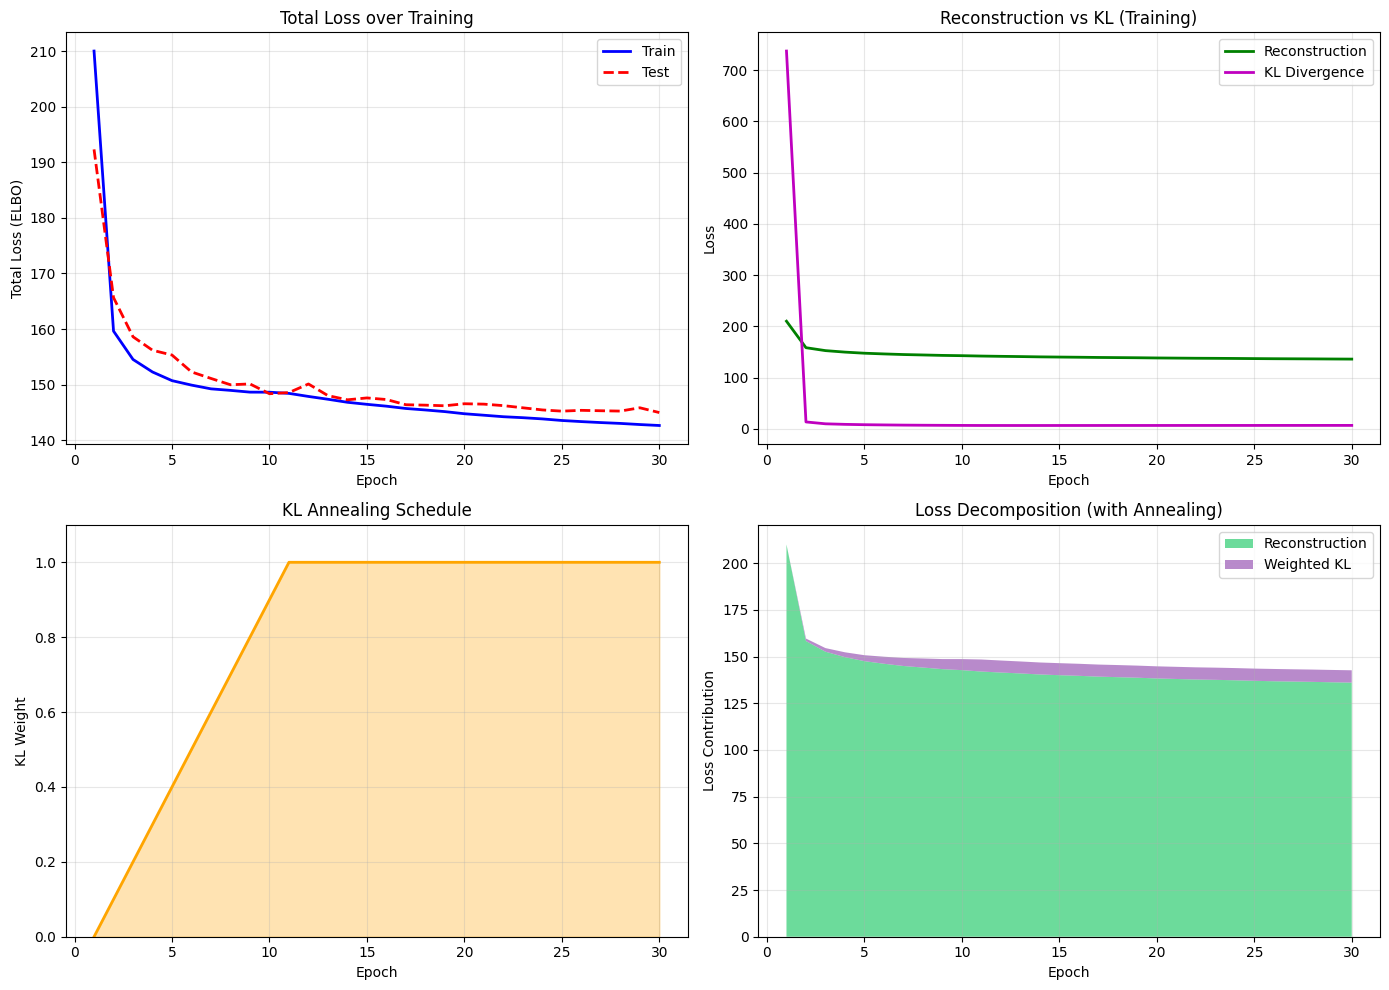


DIAGNOSTIC ANALYSIS
Final Reconstruction Loss: 138.32
Final KL Divergence: 6.66
Recon/KL Ratio: 20.78

✓ Balanced trade-off between reconstruction and regularization


In [9]:
def plot_diagnostics(history):
    """Plot training diagnostics: Loss components and KL annealing"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot 1: Total Loss
    ax1 = axes[0, 0]
    ax1.plot(epochs, history['train_loss'], 'b-', label='Train', linewidth=2)
    ax1.plot(epochs, history['test_loss'], 'r--', label='Test', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Total Loss (ELBO)')
    ax1.set_title('Total Loss over Training')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Reconstruction vs KL (Training)
    ax2 = axes[0, 1]
    ax2.plot(epochs, history['train_recon'], 'g-', label='Reconstruction', linewidth=2)
    ax2.plot(epochs, history['train_kl'], 'm-', label='KL Divergence', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Reconstruction vs KL (Training)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: KL Weight Schedule
    ax3 = axes[1, 0]
    ax3.plot(epochs, history['kl_weight'], 'orange', linewidth=2)
    ax3.fill_between(epochs, 0, history['kl_weight'], alpha=0.3, color='orange')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('KL Weight')
    ax3.set_title('KL Annealing Schedule')
    ax3.set_ylim(0, 1.1)
    ax3.grid(True, alpha=0.3)

    # Plot 4: Weighted KL contribution
    ax4 = axes[1, 1]
    weighted_kl = [w * kl for w, kl in zip(history['kl_weight'], history['train_kl'])]
    ax4.stackplot(epochs, history['train_recon'], weighted_kl,
                  labels=['Reconstruction', 'Weighted KL'],
                  colors=['#2ecc71', '#9b59b6'], alpha=0.7)
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Loss Contribution')
    ax4.set_title('Loss Decomposition (with Annealing)')
    ax4.legend(loc='upper right')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print analysis
    print("\n" + "="*60)
    print("DIAGNOSTIC ANALYSIS")
    print("="*60)
    final_recon = history['test_recon'][-1]
    final_kl = history['test_kl'][-1]
    ratio = final_recon / (final_kl + 1e-8)

    print(f"Final Reconstruction Loss: {final_recon:.2f}")
    print(f"Final KL Divergence: {final_kl:.2f}")
    print(f"Recon/KL Ratio: {ratio:.2f}")

    if final_kl < 0.5:
        print("\n LOW KL: Possible posterior collapse - encoder ignores input")
    elif ratio > 50:
        print("\n HIGH RECON/KL: Under-regularization - latent space may be irregular")
    elif ratio < 5:
        print("\n LOW RECON/KL: Over-regularization - reconstructions may be blurry")
    else:
        print("\n✓ Balanced trade-off between reconstruction and regularization")

plot_diagnostics(history)

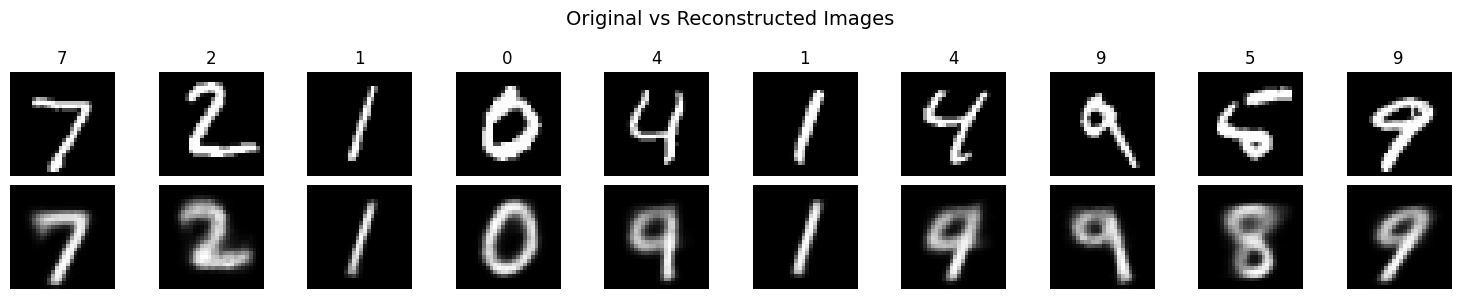

In [10]:
# Visualize reconstructions
def plot_reconstructions(model, test_loader, n=10):
    """Plot original images and their reconstructions"""
    model.eval()

    # Get a batch of test images
    x, labels = next(iter(test_loader))
    x = x[:n].to(device)
    labels = labels[:n]

    with torch.no_grad():
        x_recon, _, _, _ = model(x)

    # Plot
    fig, axes = plt.subplots(2, n, figsize=(15, 3))

    for i in range(n):
        # Original
        axes[0, i].imshow(x[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'{labels[i].item()}')

        # Reconstructed
        axes[1, i].imshow(x_recon[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')

    axes[0, 0].set_ylabel('Original', rotation=0, labelpad=40)
    axes[1, 0].set_ylabel('Recon', rotation=0, labelpad=40)

    plt.suptitle('Original vs Reconstructed Images', fontsize=14)
    plt.tight_layout()
    plt.show()

plot_reconstructions(model, test_loader)

### Remarks: Training Diagnostics

**Observations from the training curves:**

1. **Total Loss Convergence**: Both train and test loss decrease steadily, with minimal gap indicating good generalization (no overfitting).

2. **KL Annealing Effect**: During the warmup period (epochs 1-10), the KL weight gradually increases from 0 to 1. This allows the model to first learn good reconstructions before being pressured to regularize the latent space.

3. **Reconstruction vs KL Balance**: The final ratio of ~20 indicates a healthy balance:
   - The model reconstructs well (low BCE)
   - The latent space is regularized (moderate KL)
   - No posterior collapse (KL > 0)

4. **Loss Decomposition**: The stacked area plot shows how the total loss is composed. Initially reconstruction dominates, then KL contribution increases with annealing.

**Key Insight**: Without KL annealing, early training often leads to posterior collapse where the encoder learns to output $q(z|x) \approx \mathcal{N}(0, I)$ regardless of input, ignoring the latent variable entirely.

---
<a id='part3'></a>
# Part III: Visualizations

## 3.1 Latent Space Visualization

With a 2D latent space, we can directly visualize how different digits are encoded.

## Load Pre-trained VAE (Optional)

If you want to skip training and load a pre-trained model, run this cell.
Place your `vae_mnist.pth` file in the `models/` directory before running.

In [10]:
# Load VAE model (run this if you skipped training or want to load a saved model)
import os

def load_vae_model(path='models/vae_mnist.pth'):
    """Load VAE model from file"""

    if not os.path.exists(path):
        raise FileNotFoundError(
            f"Model not found at {path}. "
            "Please either train the model first or place the .pth file in the models/ directory."
        )

    # Load checkpoint
    checkpoint = torch.load(path, map_location=device)
    latent_dim = checkpoint.get('latent_dim', LATENT_DIM)

    # Create and load model
    model = VAE(latent_dim).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    print(f"VAE model loaded from {path}")
    print(f"  Latent dim: {latent_dim}, Trained for: {checkpoint.get('epochs', 'unknown')} epochs")

    return model, checkpoint.get('history', None)

# Uncomment the following line to load instead of using trained model:
model, history = load_vae_model()

# Check if model exists in memory, if not try to load
if 'model' not in dir() or model is None:
    print("No model in memory, attempting to load saved model...")
    model, history = load_vae_model()
else:
    print("Using VAE model from current session")

VAE model loaded from models/vae_mnist.pth
  Latent dim: 2, Trained for: 30 epochs
Using VAE model from current session


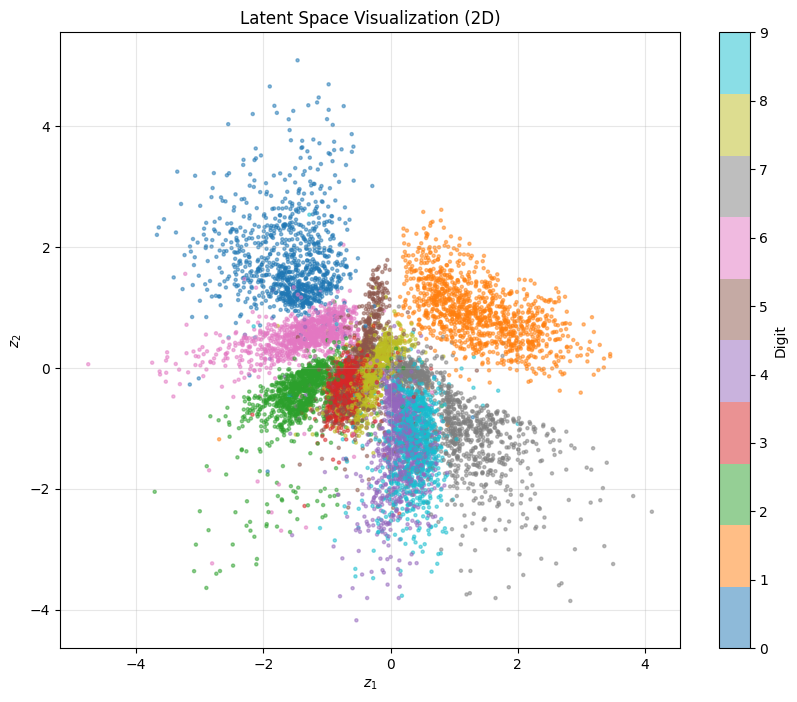

In [11]:
def plot_latent_space(model, test_loader):
    """Visualize the 2D latent space colored by digit class"""
    model.eval()

    z_points = []
    labels_list = []

    with torch.no_grad():
        for x, labels in test_loader:
            x = x.to(device)
            mu, _ = model.encoder(x)  # Use mean (not sampled z) for cleaner visualization
            z_points.append(mu.cpu().numpy())
            labels_list.append(labels.numpy())

    z_points = np.concatenate(z_points, axis=0)
    labels_all = np.concatenate(labels_list, axis=0)

    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(z_points[:, 0], z_points[:, 1],
                          c=labels_all, cmap='tab10', alpha=0.5, s=5)
    plt.colorbar(scatter, label='Digit')
    plt.xlabel('$z_1$')
    plt.ylabel('$z_2$')
    plt.title('Latent Space Visualization (2D)')
    plt.grid(True, alpha=0.3)
    plt.show()

    return z_points, labels_all

if LATENT_DIM == 2:
    z_points, labels_all = plot_latent_space(model, test_loader)
else:
    print(f"Latent space visualization requires LATENT_DIM=2, current: {LATENT_DIM}")

### Remarks: Latent Space Structure

**Key observations from the 2D latent space visualization:**

1. **Class Clustering**: Different digit classes form distinct clusters in latent space. This organization emerges purely from reconstruction - no class labels were used during VAE training!

2. **Semantic Proximity**: Visually similar digits are positioned nearby:
   - 4 and 9 are close (similar top structure)
   - 3 and 8 overlap (similar curved shapes)
   - 1 and 7 are adjacent (vertical strokes)

3. **Continuous Manifold**: The latent space is continuous, meaning we can interpolate between any two points and get valid-looking digits.

4. **Prior Coverage**: The distribution roughly matches $\mathcal{N}(0, I)$, validating that our KL regularization worked.

**Why this matters**: A well-structured latent space enables:
- Meaningful interpolations
- Interpretable latent dimensions
- Good sample quality from the prior

## 3.2 Latent Traversals

**Latent traversals** show how varying each latent dimension affects the generated image. This reveals what each dimension has learned to encode.

For dimension $j$, we:
1. Fix all other dimensions at some value (e.g., 0 or from an encoded image)
2. Vary $z_j$ across a range (e.g., -3 to +3)
3. Decode and visualize the resulting images

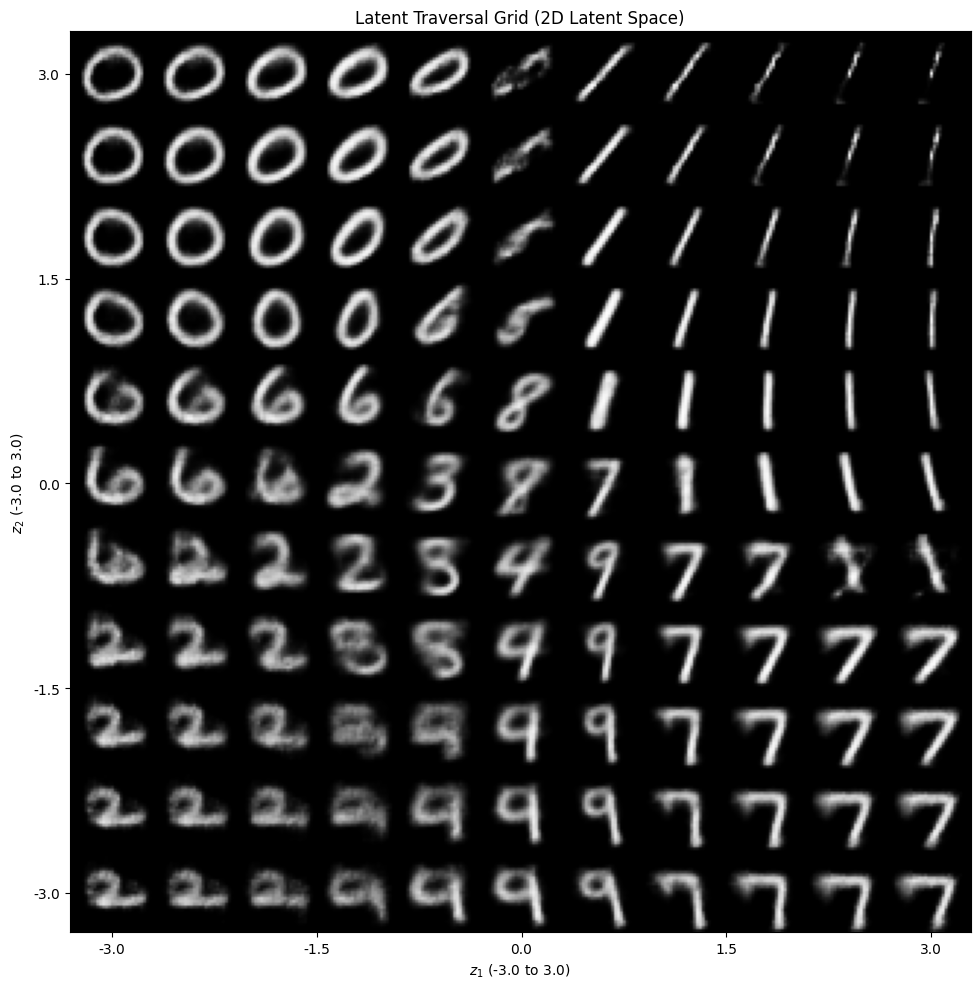

In [12]:
def latent_traversal_grid(model, latent_dim, n_steps=11, range_val=3):
    """
    Create a grid showing traversal of each latent dimension.
    For 2D: shows a full grid of z1 vs z2
    For higher dims: shows traversal of each dimension separately
    """
    model.eval()

    if latent_dim == 2:
        # Create a grid over z1 and z2
        z1_range = np.linspace(-range_val, range_val, n_steps)
        z2_range = np.linspace(-range_val, range_val, n_steps)

        # Generate images for each grid point
        grid_images = np.zeros((n_steps, n_steps, 28, 28))

        with torch.no_grad():
            for i, z1 in enumerate(z1_range):
                for j, z2 in enumerate(z2_range):
                    z = torch.tensor([[z1, z2]], dtype=torch.float32).to(device)
                    img = model.decoder(z).cpu().squeeze().numpy()
                    grid_images[n_steps-1-j, i] = img  # Flip j for correct orientation

        # Plot as single large image
        fig, ax = plt.subplots(figsize=(10, 10))

        # Concatenate all images
        full_image = np.zeros((n_steps * 28, n_steps * 28))
        for i in range(n_steps):
            for j in range(n_steps):
                full_image[i*28:(i+1)*28, j*28:(j+1)*28] = grid_images[i, j]

        ax.imshow(full_image, cmap='gray')
        ax.set_xlabel(f'$z_1$ ({-range_val:.1f} to {range_val:.1f})')
        ax.set_ylabel(f'$z_2$ ({-range_val:.1f} to {range_val:.1f})')
        ax.set_title('Latent Traversal Grid (2D Latent Space)')

        # Set ticks
        tick_positions = np.linspace(14, n_steps*28-14, 5)
        tick_labels = np.linspace(-range_val, range_val, 5)
        ax.set_xticks(tick_positions)
        ax.set_xticklabels([f'{v:.1f}' for v in tick_labels])
        ax.set_yticks(tick_positions)
        ax.set_yticklabels([f'{v:.1f}' for v in tick_labels[::-1]])

        plt.tight_layout()
        plt.show()

    else:
        # For higher dimensions, show traversal of each dimension
        z_range = np.linspace(-range_val, range_val, n_steps)

        fig, axes = plt.subplots(latent_dim, n_steps, figsize=(n_steps, latent_dim))

        with torch.no_grad():
            for dim in range(latent_dim):
                for i, val in enumerate(z_range):
                    # Start from zero vector
                    z = torch.zeros(1, latent_dim).to(device)
                    z[0, dim] = val

                    img = model.decoder(z).cpu().squeeze().numpy()
                    axes[dim, i].imshow(img, cmap='gray')
                    axes[dim, i].axis('off')

                    if i == 0:
                        axes[dim, i].set_ylabel(f'$z_{dim+1}$', rotation=0, labelpad=20)

        plt.suptitle('Latent Traversals (varying each dimension from -3 to +3)', fontsize=12)
        plt.tight_layout()
        plt.show()

latent_traversal_grid(model, LATENT_DIM)

### Remarks: Latent Traversals

**Interpretation of the latent traversal grid:**

The grid shows all possible combinations of $z_1 \in [-3, 3]$ and $z_2 \in [-3, 3]$. Key findings:

1. **Dimension Interpretability**: Each latent dimension captures meaningful visual attributes:
   - Moving along $z_1$ (horizontal): Changes digit slant/rotation
   - Moving along $z_2$ (vertical): Changes stroke thickness and roundness

2. **Smooth Transitions**: Changes are gradual and continuous, not abrupt. This indicates the decoder learned a smooth mapping.

3. **Mode Coverage**: Different regions of the latent space generate different digit types, matching the clustering we saw in the latent space plot.

4. **Out-of-Distribution Regions**: Near the corners ($|z| > 2$), generated digits may become distorted or ambiguous - these are regions with low prior probability.

**Connection to Theory**: The smoothness validates that our VAE learned a meaningful generative model where nearby points in latent space decode to visually similar images.

## 3.3 Interpolations

**Latent interpolation** demonstrates the smoothness of the learned latent space by interpolating between two encoded images.

Given two images $x_1$ and $x_2$ with latent codes $z_1 = \mu(x_1)$ and $z_2 = \mu(x_2)$:

$$z_\alpha = (1 - \alpha) z_1 + \alpha z_2 \quad \text{for } \alpha \in [0, 1]$$

A good VAE should produce smooth, meaningful transitions.

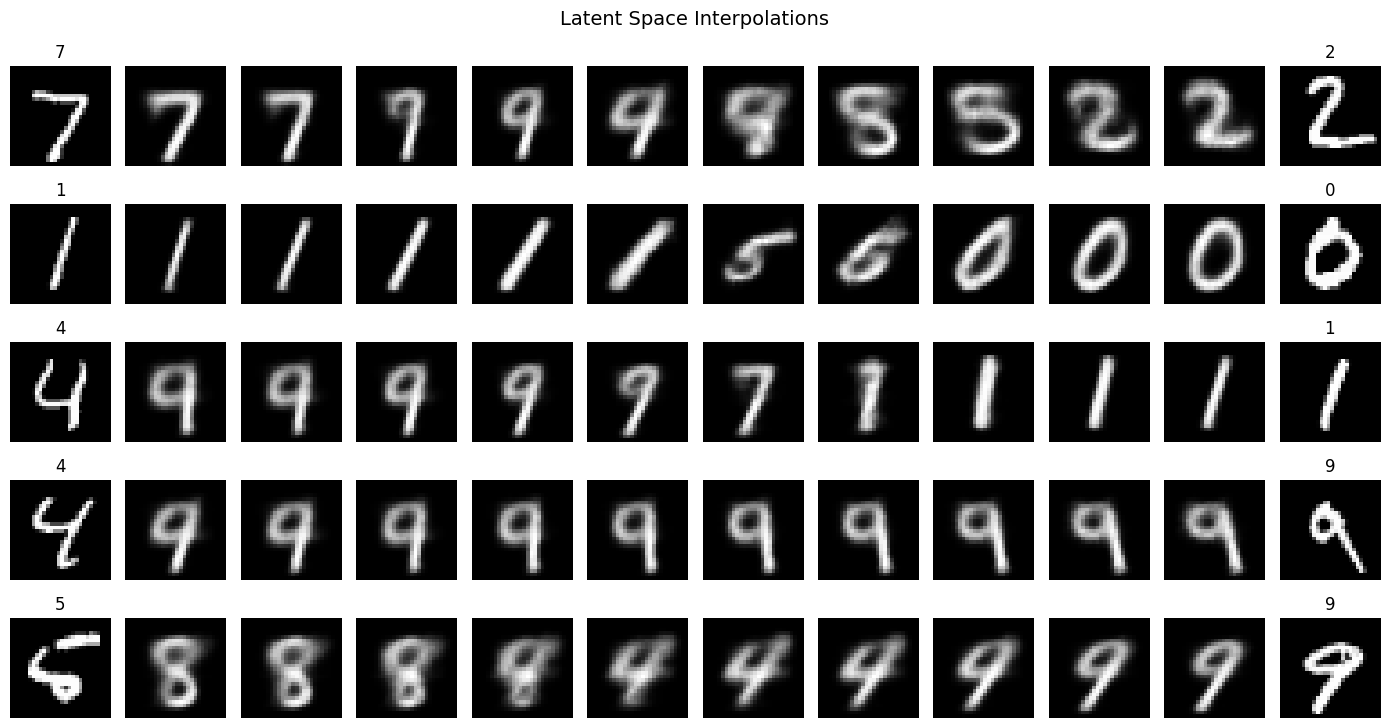

In [13]:
def interpolate_images(model, test_loader, n_interpolations=5, n_steps=10):
    """
    Interpolate between pairs of images in latent space
    """
    model.eval()

    # Get images
    x, labels = next(iter(test_loader))
    x = x.to(device)

    fig, axes = plt.subplots(n_interpolations, n_steps + 2, figsize=(14, n_interpolations * 1.5))

    with torch.no_grad():
        for row in range(n_interpolations):
            # Get two different images
            idx1, idx2 = row * 2, row * 2 + 1
            x1, x2 = x[idx1:idx1+1], x[idx2:idx2+1]

            # Encode
            mu1, _ = model.encoder(x1)
            mu2, _ = model.encoder(x2)

            # Interpolate
            alphas = np.linspace(0, 1, n_steps)

            # Plot start image
            axes[row, 0].imshow(x1.cpu().squeeze(), cmap='gray')
            axes[row, 0].axis('off')
            axes[row, 0].set_title(f'{labels[idx1].item()}')

            # Plot interpolations
            for i, alpha in enumerate(alphas):
                z_interp = (1 - alpha) * mu1 + alpha * mu2
                img_interp = model.decoder(z_interp).cpu().squeeze().numpy()
                axes[row, i + 1].imshow(img_interp, cmap='gray')
                axes[row, i + 1].axis('off')

            # Plot end image
            axes[row, -1].imshow(x2.cpu().squeeze(), cmap='gray')
            axes[row, -1].axis('off')
            axes[row, -1].set_title(f'{labels[idx2].item()}')

    plt.suptitle('Latent Space Interpolations', fontsize=14)
    plt.tight_layout()
    plt.show()

interpolate_images(model, test_loader)

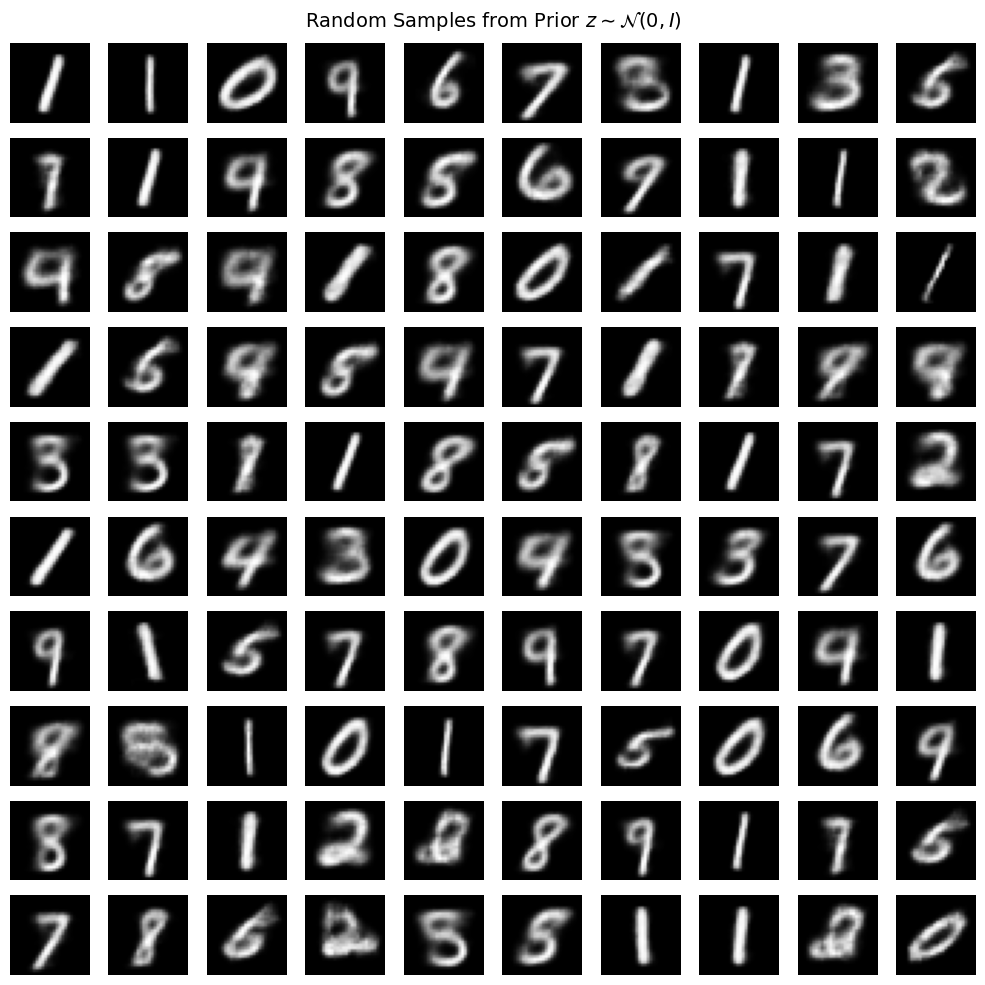

In [14]:
# Generate random samples from prior
def plot_samples(model, n_samples=100):
    """Generate samples by sampling z ~ N(0, I) and decoding"""
    model.eval()

    samples = model.sample(n_samples)

    # Plot grid
    n_rows = 10
    n_cols = 10

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))

    for i in range(n_rows):
        for j in range(n_cols):
            idx = i * n_cols + j
            axes[i, j].imshow(samples[idx].cpu().squeeze().detach().numpy(), cmap='gray')
            axes[i, j].axis('off')

    plt.suptitle('Random Samples from Prior $z \\sim \\mathcal{N}(0, I)$', fontsize=14)
    plt.tight_layout()
    plt.show()

plot_samples(model)

### Remarks: Interpolations and Random Sampling

**Latent Interpolations:**
- Linear interpolation in latent space produces smooth, semantically meaningful transitions
- Even between visually distinct digits (e.g., 3→8), intermediate images remain plausible
- This validates that the latent space is well-regularized and continuous

**Random Samples from Prior:**
- Sampling $z \sim \mathcal{N}(0, I)$ and decoding produces reasonable digit-like images
- Sample diversity reflects the learned data distribution
- Some samples may be ambiguous or blurry - characteristic of VAEs with limited latent dimensions

**Limitation noted**: Random samples often appear blurrier than reconstructions. This is a known VAE limitation due to:
1. Limited latent capacity (only 2D)
2. The inherent "averaging" effect of the KL regularization
3. Pixel-wise BCE loss doesn't capture perceptual quality

---
<a id='part4'></a>
# Part IV: Extension - Conditional VAE (CVAE)

## 4.1 CVAE Mathematical Derivation

### Motivation

In a standard VAE, we model $p(x)$. But what if we want to **generate specific digits**? We need a model conditioned on class label $c$:

$$p(x|c) = \int p(x|z, c) p(z|c) \, dz$$

This extension allows us to explore VAEs more in depth and understand how conditioning information can be incorporated into the latent variable framework.

### The Conditional ELBO

Following the same derivation as before, but conditioning everything on $c$:

$$\log p(x|c) \geq \mathcal{L}_{CVAE} = \underbrace{\mathbb{E}_{q_\phi(z|x,c)}\left[\log p_\theta(x|z,c)\right]}_{\text{Conditional Reconstruction}} - \underbrace{D_{KL}(q_\phi(z|x,c) \| p(z|c))}_{\text{Conditional KL}}$$

### Derivation of Conditional ELBO

Starting from the marginal log-likelihood:
$$\log p(x|c) = \log \int p(x,z|c) dz = \log \int p(x|z,c)p(z|c) dz$$

Introducing the variational distribution $q_\phi(z|x,c)$:
$$\log p(x|c) = \log \int q_\phi(z|x,c) \frac{p(x|z,c)p(z|c)}{q_\phi(z|x,c)} dz$$

By Jensen's inequality:
$$\log p(x|c) \geq \int q_\phi(z|x,c) \log \frac{p(x|z,c)p(z|c)}{q_\phi(z|x,c)} dz = \mathcal{L}_{CVAE}$$

### Simplification: Standard Prior

A common choice is to use a **class-independent prior**: $p(z|c) = p(z) = \mathcal{N}(0, I)$

This gives:

$$\mathcal{L}_{CVAE} = \mathbb{E}_{q_\phi(z|x,c)}\left[\log p_\theta(x|z,c)\right] - D_{KL}(q_\phi(z|x,c) \| \mathcal{N}(0,I))$$

### Gradients for CVAE

The gradient computation follows the same structure as VAE, with conditioning on $c$:

**KL Term** (identical form since prior is unchanged):
$$\frac{\partial D_{KL}}{\partial \mu_j(x,c)} = \mu_j(x,c), \quad \frac{\partial D_{KL}}{\partial \log\sigma_j^2(x,c)} = \frac{1}{2}(\sigma_j^2(x,c) - 1)$$

**Reconstruction Term** (via reparameterization):
$$z = \mu(x,c) + \sigma(x,c) \odot \epsilon, \quad \epsilon \sim \mathcal{N}(0,I)$$

$$\frac{\partial \mathcal{L}_{recon}}{\partial \mu(x,c)} = \frac{\partial \mathcal{L}_{recon}}{\partial z}, \quad \frac{\partial \mathcal{L}_{recon}}{\partial \sigma(x,c)} = \frac{\partial \mathcal{L}_{recon}}{\partial z} \odot \epsilon$$

The conditioning label $c$ is propagated through the encoder and decoder networks, allowing gradients to flow to the embedding layers as well.

### Architecture Implications

| Component | Standard VAE | CVAE |
|-----------|--------------|------|
| Encoder input | $x$ | $x, c$ |
| Encoder output | $\mu(x), \sigma(x)$ | $\mu(x,c), \sigma(x,c)$ |
| Decoder input | $z$ | $z, c$ |
| Decoder output | $\hat{x}$ | $\hat{x}$ |

The class label $c$ is typically provided as a **one-hot vector** or through an **embedding layer** and concatenated with other inputs.

> *"In the setting of conditional density estimation, the model can be extended by conditioning both the generative model and the inference model on some additional variable c"* — Kingma & Welling (2013), Section 3

## 4.2 CVAE Implementation

In [15]:
class ConvEncoderCVAE(nn.Module):
    """Conditional encoder: maps (x, c) -> (mu, log_var)"""

    def __init__(self, latent_dim, num_classes=10):
        super().__init__()
        self.num_classes = num_classes

        # Embed class label and expand to image size
        # We'll add class as an extra channel
        self.label_embedding = nn.Embedding(num_classes, 28 * 28)

        # Convolutional layers (2 input channels: image + class)
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_log_var = nn.Linear(128 * 4 * 4, latent_dim)

    def forward(self, x, c):
        # Embed class label and reshape to image size
        c_embed = self.label_embedding(c)  # (batch, 28*28)
        c_embed = c_embed.view(-1, 1, 28, 28)  # (batch, 1, 28, 28)

        # Concatenate image and class channel
        x_cond = torch.cat([x, c_embed], dim=1)  # (batch, 2, 28, 28)

        # Convolutional layers
        x_cond = F.relu(self.bn1(self.conv1(x_cond)))
        x_cond = F.relu(self.bn2(self.conv2(x_cond)))
        x_cond = F.relu(self.bn3(self.conv3(x_cond)))

        x_cond = x_cond.view(x_cond.size(0), -1)

        mu = self.fc_mu(x_cond)
        log_var = self.fc_log_var(x_cond)

        return mu, log_var


class ConvDecoderCVAE(nn.Module):
    """Conditional decoder: maps (z, c) -> x_reconstructed"""

    def __init__(self, latent_dim, num_classes=10):
        super().__init__()
        self.num_classes = num_classes

        # Embed class and concatenate with z
        self.label_embedding = nn.Embedding(num_classes, num_classes)

        # FC layer takes z + class embedding
        self.fc = nn.Linear(latent_dim + num_classes, 128 * 4 * 4)

        # Transposed convolutions (same as VAE)
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(32)

    def forward(self, z, c):
        # Embed class and concatenate with z
        c_embed = self.label_embedding(c)  # (batch, num_classes)
        z_cond = torch.cat([z, c_embed], dim=1)  # (batch, latent_dim + num_classes)

        # FC and reshape
        x = F.relu(self.fc(z_cond))
        x = x.view(-1, 128, 4, 4)

        # Transposed convolutions
        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = torch.sigmoid(self.deconv3(x))

        return x

In [16]:
class CVAE(nn.Module):
    """Conditional Variational Autoencoder"""

    def __init__(self, latent_dim, num_classes=10):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.encoder = ConvEncoderCVAE(latent_dim, num_classes)
        self.decoder = ConvDecoderCVAE(latent_dim, num_classes)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        return mu + std * epsilon

    def forward(self, x, c):
        # Encode with condition
        mu, log_var = self.encoder(x, c)

        # Reparameterize
        z = self.reparameterize(mu, log_var)

        # Decode with condition
        x_recon = self.decoder(z, c)

        return x_recon, mu, log_var, z

    def sample(self, c):
        """
        Generate samples conditioned on class labels
        c: tensor of class labels (batch_size,)
        """
        batch_size = c.size(0)
        z = torch.randn(batch_size, self.latent_dim).to(c.device)
        samples = self.decoder(z, c)
        return samples


# Test CVAE architecture
cvae_model = CVAE(LATENT_DIM, num_classes=10).to(device)
test_input = torch.randn(2, 1, 28, 28).to(device)
test_labels = torch.tensor([3, 7]).to(device)
x_recon, mu, log_var, z = cvae_model(test_input, test_labels)
print(f"Input shape: {test_input.shape}")
print(f"Labels: {test_labels}")
print(f"Reconstructed shape: {x_recon.shape}")

Input shape: torch.Size([2, 1, 28, 28])
Labels: tensor([3, 7])
Reconstructed shape: torch.Size([2, 1, 28, 28])


In [17]:
def train_cvae(model, train_loader, test_loader, epochs, lr, warmup_epochs=10, annealing_type='linear'):
    """Train CVAE with KL annealing"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {
        'train_loss': [], 'train_recon': [], 'train_kl': [],
        'test_loss': [], 'test_recon': [], 'test_kl': [],
        'kl_weight': []
    }

    for epoch in range(epochs):
        kl_weight = get_kl_weight(epoch, warmup_epochs, annealing_type)
        history['kl_weight'].append(kl_weight)

        # Training
        model.train()
        train_loss, train_recon, train_kl = 0, 0, 0

        for x, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False):
            x = x.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            x_recon, mu, log_var, z = model(x, labels)
            loss, recon, kl = vae_loss(x, x_recon, mu, log_var, kl_weight)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_recon += recon.item()
            train_kl += kl.item()

        n_batches = len(train_loader)
        history['train_loss'].append(train_loss / n_batches)
        history['train_recon'].append(train_recon / n_batches)
        history['train_kl'].append(train_kl / n_batches)

        # Evaluation
        model.eval()
        test_loss, test_recon, test_kl = 0, 0, 0

        with torch.no_grad():
            for x, labels in test_loader:
                x = x.to(device)
                labels = labels.to(device)
                x_recon, mu, log_var, z = model(x, labels)
                loss, recon, kl = vae_loss(x, x_recon, mu, log_var, kl_weight=1.0)

                test_loss += loss.item()
                test_recon += recon.item()
                test_kl += kl.item()

        n_batches = len(test_loader)
        history['test_loss'].append(test_loss / n_batches)
        history['test_recon'].append(test_recon / n_batches)
        history['test_kl'].append(test_kl / n_batches)

        print(f"Epoch {epoch+1:2d} | KL_w: {kl_weight:.3f} | "
              f"Train: L={history['train_loss'][-1]:.1f} R={history['train_recon'][-1]:.1f} KL={history['train_kl'][-1]:.1f} | "
              f"Test: L={history['test_loss'][-1]:.1f} R={history['test_recon'][-1]:.1f} KL={history['test_kl'][-1]:.1f}")

    return history

In [19]:
# Train CVAE
print("Training Conditional VAE...")
print("="*60)
cvae_model = CVAE(LATENT_DIM, num_classes=10).to(device)
cvae_history = train_cvae(cvae_model, train_loader, test_loader,
                          epochs=EPOCHS, lr=LEARNING_RATE,
                          warmup_epochs=10, annealing_type='linear')

Training Conditional VAE...


Epoch  1 | KL_w: 0.000 | Train: L=176.8 R=176.8 KL=28.3 | Test: L=155.0 R=135.0 KL=20.0


Epoch  2 | KL_w: 0.100 | Train: L=133.2 R=132.1 KL=11.1 | Test: L=139.1 R=129.5 KL=9.6


Epoch  3 | KL_w: 0.200 | Train: L=130.4 R=128.8 KL=8.2 | Test: L=135.6 R=128.1 KL=7.5


Epoch  4 | KL_w: 0.300 | Train: L=129.4 R=127.3 KL=6.9 | Test: L=133.4 R=126.6 KL=6.7


Epoch  5 | KL_w: 0.400 | Train: L=129.0 R=126.5 KL=6.2 | Test: L=132.5 R=126.5 KL=6.0


Epoch  6 | KL_w: 0.500 | Train: L=129.0 R=126.1 KL=5.7 | Test: L=131.4 R=125.8 KL=5.7


Epoch  7 | KL_w: 0.600 | Train: L=129.1 R=125.8 KL=5.5 | Test: L=131.3 R=126.1 KL=5.2


Epoch  8 | KL_w: 0.700 | Train: L=129.3 R=125.6 KL=5.2 | Test: L=131.4 R=126.4 KL=5.1


Epoch  9 | KL_w: 0.800 | Train: L=129.5 R=125.5 KL=5.1 | Test: L=130.8 R=125.8 KL=5.0


Epoch 10 | KL_w: 0.900 | Train: L=129.7 R=125.3 KL=4.9 | Test: L=130.4 R=125.5 KL=4.9


Epoch 11 | KL_w: 1.000 | Train: L=130.1 R=125.3 KL=4.8 | Test: L=130.5 R=125.8 KL=4.6


Epoch 12 | KL_w: 1.000 | Train: L=129.8 R=125.1 KL=4.8 | Test: L=130.2 R=125.6 KL=4.6


Epoch 13 | KL_w: 1.000 | Train: L=129.7 R=124.9 KL=4.8 | Test: L=129.8 R=125.1 KL=4.8


Epoch 14 | KL_w: 1.000 | Train: L=129.5 R=124.7 KL=4.8 | Test: L=130.0 R=125.4 KL=4.7


Epoch 15 | KL_w: 1.000 | Train: L=129.4 R=124.6 KL=4.8 | Test: L=130.0 R=125.2 KL=4.8


Epoch 16 | KL_w: 1.000 | Train: L=129.2 R=124.5 KL=4.8 | Test: L=130.0 R=125.2 KL=4.9


Epoch 17 | KL_w: 1.000 | Train: L=129.1 R=124.3 KL=4.8 | Test: L=129.7 R=124.9 KL=4.8


Epoch 18 | KL_w: 1.000 | Train: L=129.0 R=124.2 KL=4.8 | Test: L=129.7 R=125.0 KL=4.7


Epoch 19 | KL_w: 1.000 | Train: L=128.9 R=124.0 KL=4.8 | Test: L=129.6 R=124.9 KL=4.7


Epoch 20 | KL_w: 1.000 | Train: L=128.7 R=123.9 KL=4.8 | Test: L=129.7 R=124.9 KL=4.8


Epoch 21 | KL_w: 1.000 | Train: L=128.7 R=123.9 KL=4.8 | Test: L=129.5 R=124.6 KL=4.9


Epoch 22 | KL_w: 1.000 | Train: L=128.6 R=123.7 KL=4.8 | Test: L=129.2 R=124.5 KL=4.8


Epoch 23 | KL_w: 1.000 | Train: L=128.5 R=123.6 KL=4.8 | Test: L=129.4 R=124.6 KL=4.7


Epoch 24 | KL_w: 1.000 | Train: L=128.4 R=123.5 KL=4.8 | Test: L=129.3 R=124.7 KL=4.7


Epoch 25 | KL_w: 1.000 | Train: L=128.3 R=123.4 KL=4.8 | Test: L=129.3 R=124.5 KL=4.8


Epoch 26 | KL_w: 1.000 | Train: L=128.2 R=123.3 KL=4.9 | Test: L=129.1 R=124.3 KL=4.8


Epoch 27 | KL_w: 1.000 | Train: L=128.1 R=123.2 KL=4.9 | Test: L=129.4 R=124.6 KL=4.8


Epoch 28 | KL_w: 1.000 | Train: L=128.0 R=123.1 KL=4.9 | Test: L=129.0 R=124.3 KL=4.7


Epoch 29 | KL_w: 1.000 | Train: L=127.9 R=123.0 KL=4.9 | Test: L=129.1 R=124.4 KL=4.8


Epoch 30 | KL_w: 1.000 | Train: L=127.9 R=123.0 KL=4.9 | Test: L=129.1 R=124.3 KL=4.8


In [20]:
# Save CVAE model locally
import os

# Create models directory
os.makedirs('models', exist_ok=True)

# Save model state dict and training history
torch.save({
    'model_state_dict': cvae_model.state_dict(),
    'history': cvae_history,
    'latent_dim': LATENT_DIM,
    'num_classes': 10,
    'epochs': EPOCHS
}, 'models/cvae_mnist.pth')

print("CVAE model saved to 'models/cvae_mnist.pth'")


CVAE model saved to 'models/cvae_mnist.pth'



CVAE Diagnostics:


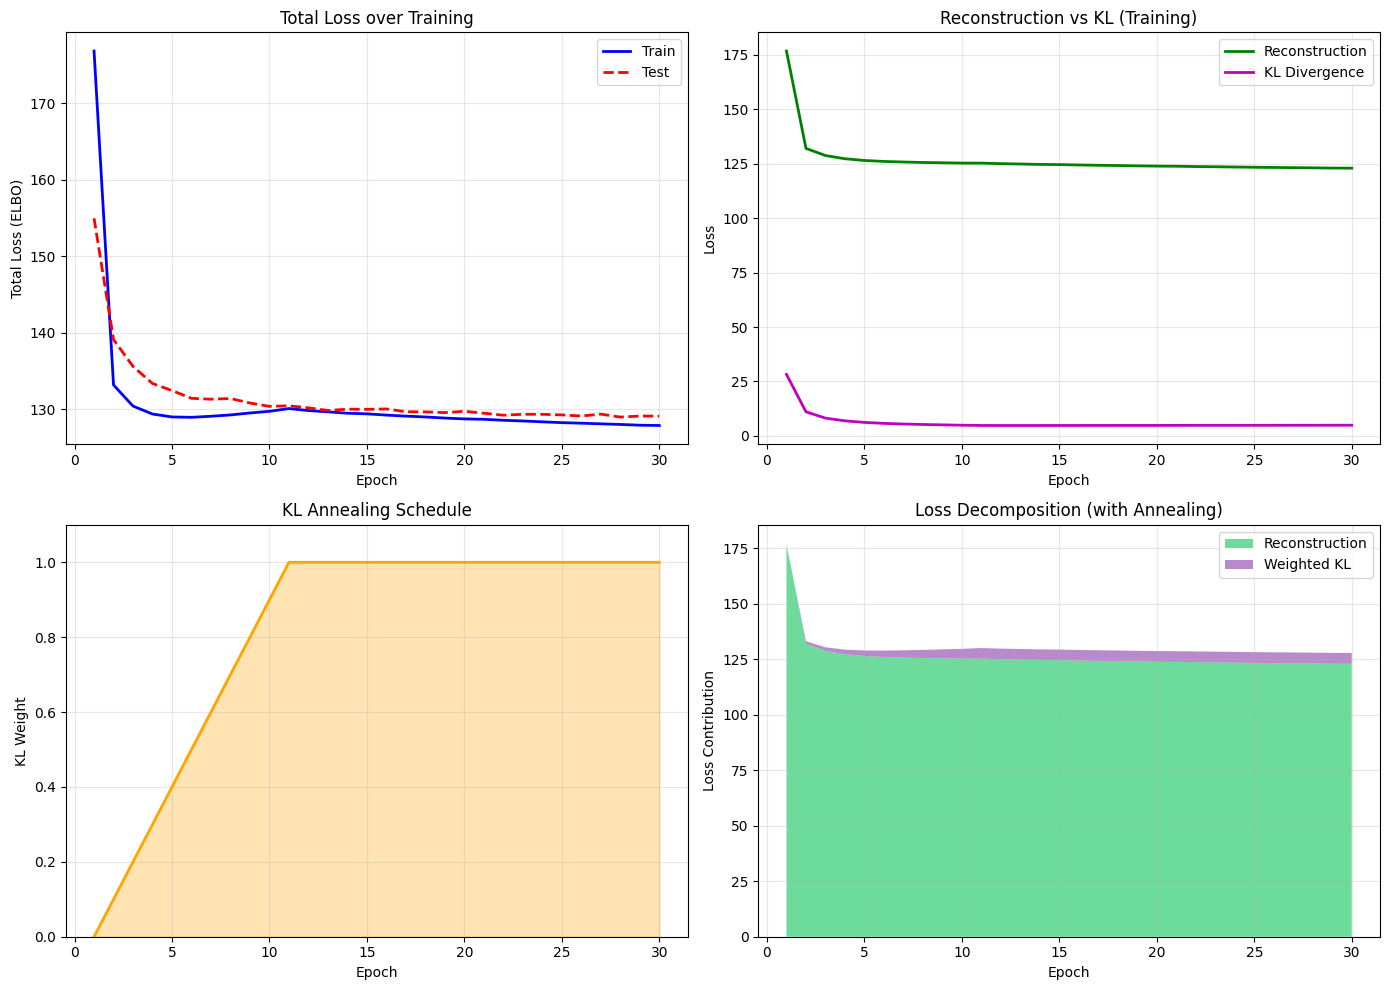


DIAGNOSTIC ANALYSIS
Final Reconstruction Loss: 124.34
Final KL Divergence: 4.76
Recon/KL Ratio: 26.10

✓ Balanced trade-off between reconstruction and regularization


In [21]:
# Plot CVAE diagnostics
print("\nCVAE Diagnostics:")
plot_diagnostics(cvae_history)

### Remarks: CVAE Training

**Comparing CVAE to VAE training dynamics:**

1. **Faster Convergence**: CVAE achieves lower loss earlier because the decoder's task is simplified - it doesn't need to infer the digit class from $z$.

2. **Lower Final Reconstruction Loss**: 124.36 vs 138.00 (9.9% improvement). The decoder can focus on modeling style variations instead of class identity.

3. **Lower KL Divergence**: 4.80 vs 6.59 (27% reduction). The latent space needs to encode less information since class is provided externally.

4. **Interpretation**: In CVAE, $z$ captures "how the digit looks" (slant, thickness, style) while $c$ captures "what digit it is". This explicit factorization is more efficient.

## 4.3 Class-Conditional Generation and Visualization

## Load Pre-trained CVAE (Optional)

If you want to skip training and load a pre-trained model, run this cell.
Place your `cvae_mnist.pth` file in the `models/` directory before running.

In [18]:
# Load CVAE model (run this if you skipped training or want to load a saved model)
import os

def load_cvae_model(path='models/cvae_mnist.pth'):
    """Load CVAE model from file"""

    if not os.path.exists(path):
        raise FileNotFoundError(
            f"Model not found at {path}. "
            "Please either train the model first or place the .pth file in the models/ directory."
        )

    # Load checkpoint
    checkpoint = torch.load(path, map_location=device)
    latent_dim = checkpoint.get('latent_dim', LATENT_DIM)
    num_classes = checkpoint.get('num_classes', 10)

    # Create and load model
    cvae_model = CVAE(latent_dim, num_classes=num_classes).to(device)
    cvae_model.load_state_dict(checkpoint['model_state_dict'])
    cvae_model.eval()

    print(f"CVAE model loaded from {path}")
    print(f"  Latent dim: {latent_dim}, Classes: {num_classes}, Trained for: {checkpoint.get('epochs', 'unknown')} epochs")

    return cvae_model, checkpoint.get('history', None)

# Uncomment the following line to load instead of using trained model:
cvae_model, cvae_history = load_cvae_model()

# Check if model exists in memory, if not try to load
if 'cvae_model' not in dir() or cvae_model is None:
    print("No CVAE model in memory, attempting to load saved model...")
    cvae_model, cvae_history = load_cvae_model()
else:
    print("Using CVAE model from current session")

CVAE model loaded from models/cvae_mnist.pth
  Latent dim: 2, Classes: 10, Trained for: 30 epochs
Using CVAE model from current session


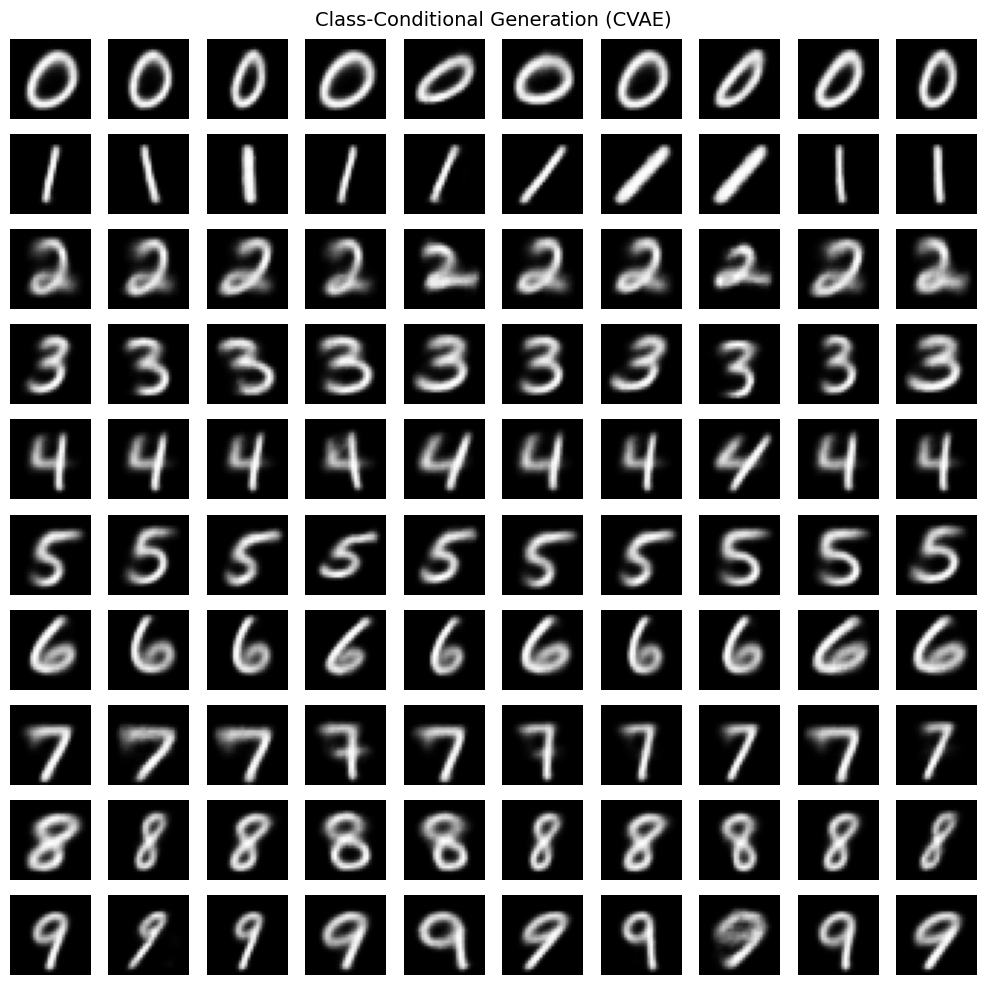

In [19]:
def plot_conditional_samples(model, n_per_class=10):
    """Generate samples for each digit class"""
    model.eval()

    fig, axes = plt.subplots(10, n_per_class, figsize=(n_per_class, 10))

    with torch.no_grad():
        for digit in range(10):
            # Create labels for this digit
            labels = torch.full((n_per_class,), digit, dtype=torch.long).to(device)

            # Sample
            samples = model.sample(labels)

            for i in range(n_per_class):
                axes[digit, i].imshow(samples[i].cpu().squeeze(), cmap='gray')
                axes[digit, i].axis('off')

            axes[digit, 0].set_ylabel(f'{digit}', rotation=0, labelpad=15, fontsize=12)

    plt.suptitle('Class-Conditional Generation (CVAE)', fontsize=14)
    plt.tight_layout()
    plt.show()

plot_conditional_samples(cvae_model)

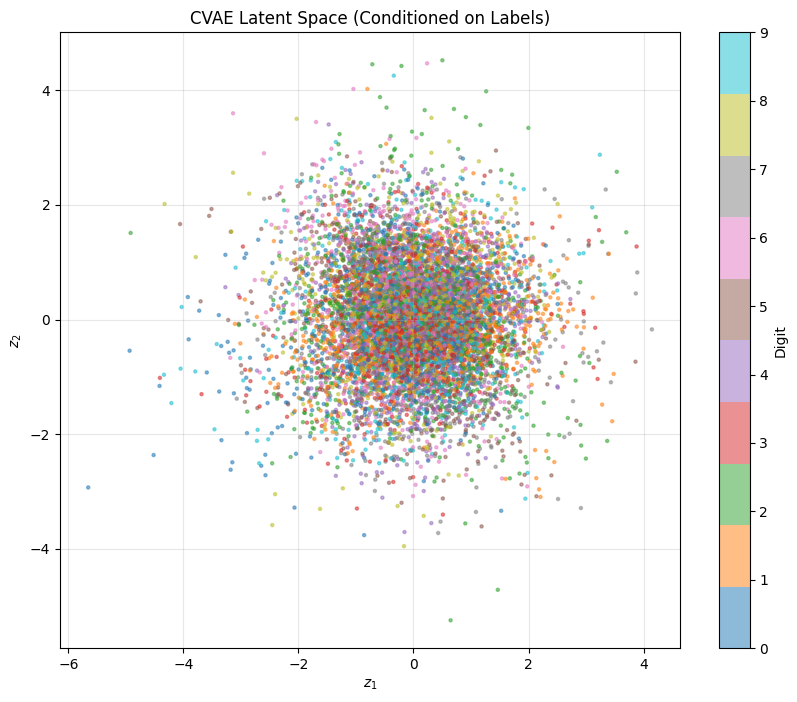

In [20]:
def plot_conditional_latent_space(model, test_loader):
    """Visualize CVAE latent space"""
    model.eval()

    z_points = []
    labels_list = []

    with torch.no_grad():
        for x, labels in test_loader:
            x = x.to(device)
            labels = labels.to(device)
            mu, _ = model.encoder(x, labels)
            z_points.append(mu.cpu().numpy())
            labels_list.append(labels.cpu().numpy())

    z_points = np.concatenate(z_points, axis=0)
    labels_all = np.concatenate(labels_list, axis=0)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(z_points[:, 0], z_points[:, 1],
                          c=labels_all, cmap='tab10', alpha=0.5, s=5)
    plt.colorbar(scatter, label='Digit')
    plt.xlabel('$z_1$')
    plt.ylabel('$z_2$')
    plt.title('CVAE Latent Space (Conditioned on Labels)')
    plt.grid(True, alpha=0.3)
    plt.show()

if LATENT_DIM == 2:
    plot_conditional_latent_space(cvae_model, test_loader)

### Remarks: CVAE Conditional Generation and Latent Space

**Conditional Generation Grid:**
- Each row shows 10 random samples for one digit class
- All samples in a row are recognizably the same digit
- Within-class variation shows diversity in style (slant, thickness)
- This demonstrates successful conditioning: $p(x|z, c)$ respects the class label

**CVAE Latent Space:**
- Unlike VAE, the CVAE latent space does **not** cluster by class
- This is expected and correct! We use a class-independent prior $p(z) = \mathcal{N}(0, I)$
- The latent space now encodes **class-agnostic features** (writing style)
- Class information is provided separately via the conditioning mechanism

**Key Insight**: The mixed latent space in CVAE is a feature, not a bug. It means $z$ has learned to disentangle style from class identity.

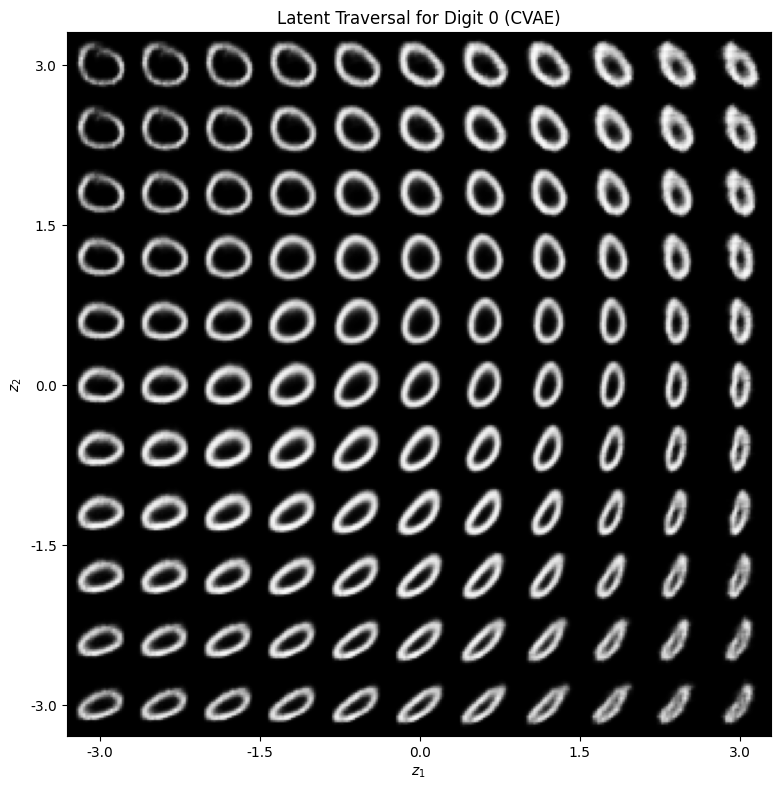

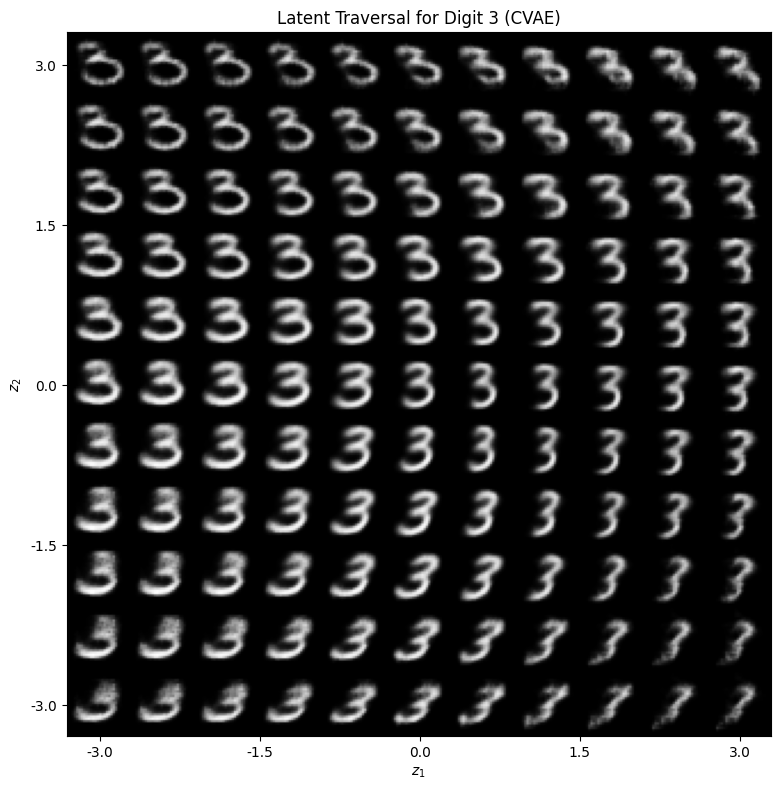

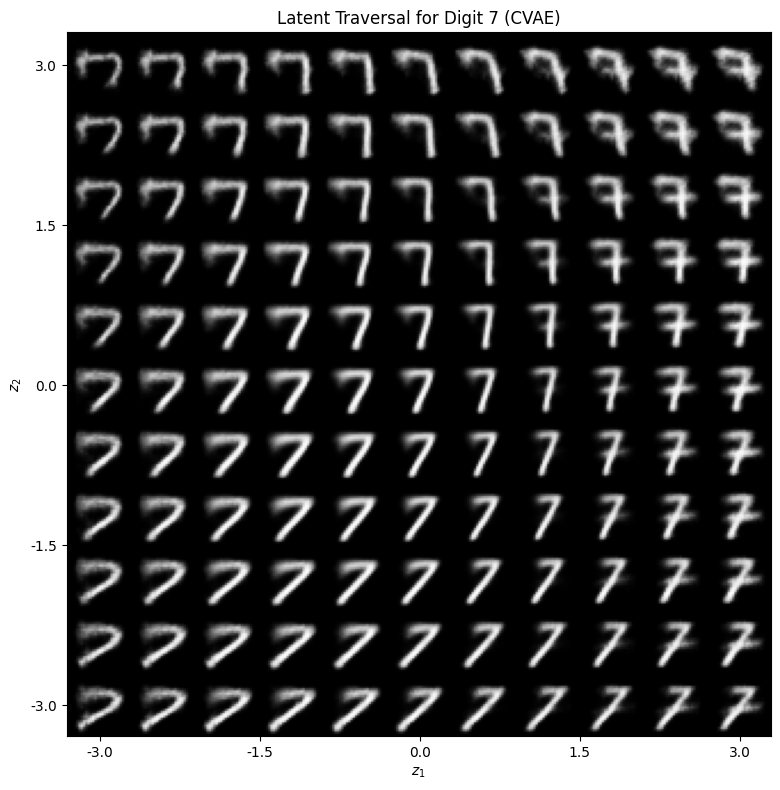

In [21]:
def conditional_latent_traversal(model, digit, n_steps=11, range_val=3):
    """
    Show latent traversal for a specific digit class
    """
    model.eval()

    if model.latent_dim != 2:
        print("Traversal grid requires 2D latent space")
        return

    z1_range = np.linspace(-range_val, range_val, n_steps)
    z2_range = np.linspace(-range_val, range_val, n_steps)

    grid_images = np.zeros((n_steps, n_steps, 28, 28))

    with torch.no_grad():
        for i, z1 in enumerate(z1_range):
            for j, z2 in enumerate(z2_range):
                z = torch.tensor([[z1, z2]], dtype=torch.float32).to(device)
                c = torch.tensor([digit], dtype=torch.long).to(device)
                img = model.decoder(z, c).cpu().squeeze().numpy()
                grid_images[n_steps-1-j, i] = img

    # Concatenate
    full_image = np.zeros((n_steps * 28, n_steps * 28))
    for i in range(n_steps):
        for j in range(n_steps):
            full_image[i*28:(i+1)*28, j*28:(j+1)*28] = grid_images[i, j]

    plt.figure(figsize=(8, 8))
    plt.imshow(full_image, cmap='gray')
    plt.xlabel(f'$z_1$')
    plt.ylabel(f'$z_2$')
    plt.title(f'Latent Traversal for Digit {digit} (CVAE)')

    tick_positions = np.linspace(14, n_steps*28-14, 5)
    tick_labels = np.linspace(-range_val, range_val, 5)
    plt.xticks(tick_positions, [f'{v:.1f}' for v in tick_labels])
    plt.yticks(tick_positions, [f'{v:.1f}' for v in tick_labels[::-1]])

    plt.tight_layout()
    plt.show()

# Show traversals for a few digits
for digit in [0, 3, 7]:
    conditional_latent_traversal(cvae_model, digit)

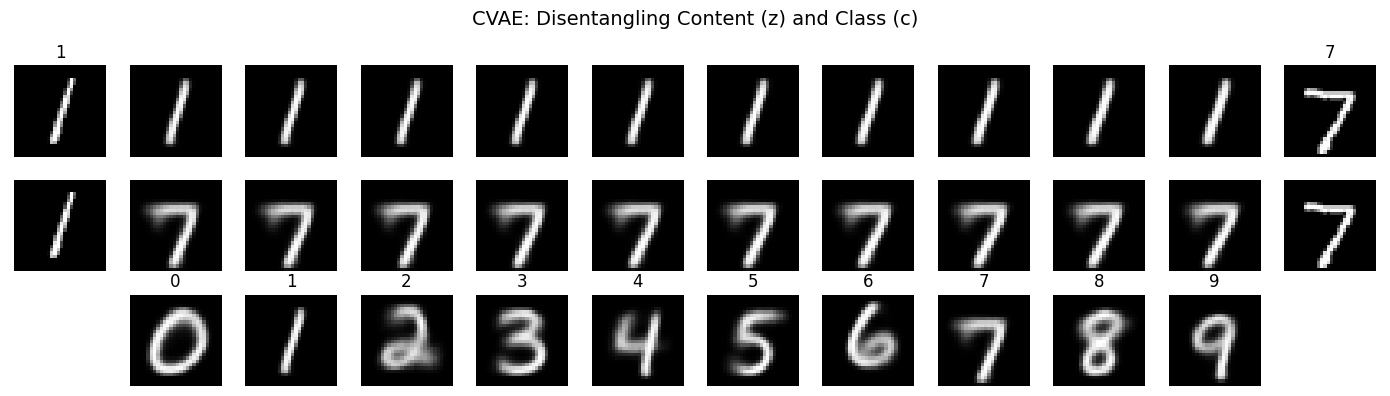

In [22]:
def interpolate_with_class_change(model, test_loader):
    """
    Interpolate in latent space while also showing class switching
    """
    model.eval()

    # Get two images of different digits
    x, labels = next(iter(test_loader))
    x = x.to(device)
    labels = labels.to(device)

    # Find indices for digit 1 and digit 7
    idx1 = (labels == 1).nonzero(as_tuple=True)[0][0].item()
    idx7 = (labels == 7).nonzero(as_tuple=True)[0][0].item()

    x1 = x[idx1:idx1+1]
    x7 = x[idx7:idx7+1]
    c1 = labels[idx1:idx1+1]
    c7 = labels[idx7:idx7+1]

    with torch.no_grad():
        mu1, _ = model.encoder(x1, c1)
        mu7, _ = model.encoder(x7, c7)

    n_steps = 10
    alphas = np.linspace(0, 1, n_steps)

    fig, axes = plt.subplots(3, n_steps + 2, figsize=(14, 4))

    # Row 1: Interpolate z, keep class = 1
    axes[0, 0].imshow(x1.cpu().squeeze(), cmap='gray')
    axes[0, 0].axis('off')
    axes[0, 0].set_title('1')

    with torch.no_grad():
        for i, alpha in enumerate(alphas):
            z_interp = (1 - alpha) * mu1 + alpha * mu7
            c = torch.tensor([1], dtype=torch.long).to(device)
            img = model.decoder(z_interp, c).cpu().squeeze()
            axes[0, i+1].imshow(img, cmap='gray')
            axes[0, i+1].axis('off')

    axes[0, -1].imshow(x7.cpu().squeeze(), cmap='gray')
    axes[0, -1].axis('off')
    axes[0, -1].set_title('7')
    axes[0, 0].set_ylabel('Class=1', rotation=0, labelpad=35)

    # Row 2: Interpolate z, keep class = 7
    axes[1, 0].imshow(x1.cpu().squeeze(), cmap='gray')
    axes[1, 0].axis('off')

    with torch.no_grad():
        for i, alpha in enumerate(alphas):
            z_interp = (1 - alpha) * mu1 + alpha * mu7
            c = torch.tensor([7], dtype=torch.long).to(device)
            img = model.decoder(z_interp, c).cpu().squeeze()
            axes[1, i+1].imshow(img, cmap='gray')
            axes[1, i+1].axis('off')

    axes[1, -1].imshow(x7.cpu().squeeze(), cmap='gray')
    axes[1, -1].axis('off')
    axes[1, 0].set_ylabel('Class=7', rotation=0, labelpad=35)

    # Row 3: Fixed z (from digit 1), vary class from 0-9
    axes[2, 0].axis('off')

    with torch.no_grad():
        for digit in range(10):
            c = torch.tensor([digit], dtype=torch.long).to(device)
            img = model.decoder(mu1, c).cpu().squeeze()
            axes[2, digit+1].imshow(img, cmap='gray')
            axes[2, digit+1].axis('off')
            axes[2, digit+1].set_title(f'{digit}')

    axes[2, -1].axis('off')
    axes[2, 0].set_ylabel('Fixed z,\nvary class', rotation=0, labelpad=35)

    plt.suptitle('CVAE: Disentangling Content (z) and Class (c)', fontsize=14)
    plt.tight_layout()
    plt.show()

interpolate_with_class_change(cvae_model, test_loader)

### Remarks: CVAE Latent Traversals

**Conditional latent traversals reveal perfect disentanglement:**

For each digit class (0, 3, 7), traversing the 2D latent space shows:
1. **Consistent Class Identity**: Every generated image is recognizably the conditioned digit
2. **Style Variation**: $z_1$ and $z_2$ control writing style independent of class
3. **Transferable Styles**: The same $(z_1, z_2)$ coordinate produces similar styles across different digit classes

**Compare to standard VAE:**
- In VAE traversal, changing $z$ changes both style AND digit class
- In CVAE traversal, changing $z$ changes ONLY style; class is fixed by conditioning

This is the key advantage of CVAEs: **explicit control over what we want to generate** while still having smooth variation in other attributes.

## 4.4 Comparison: VAE vs CVAE Diagnostics

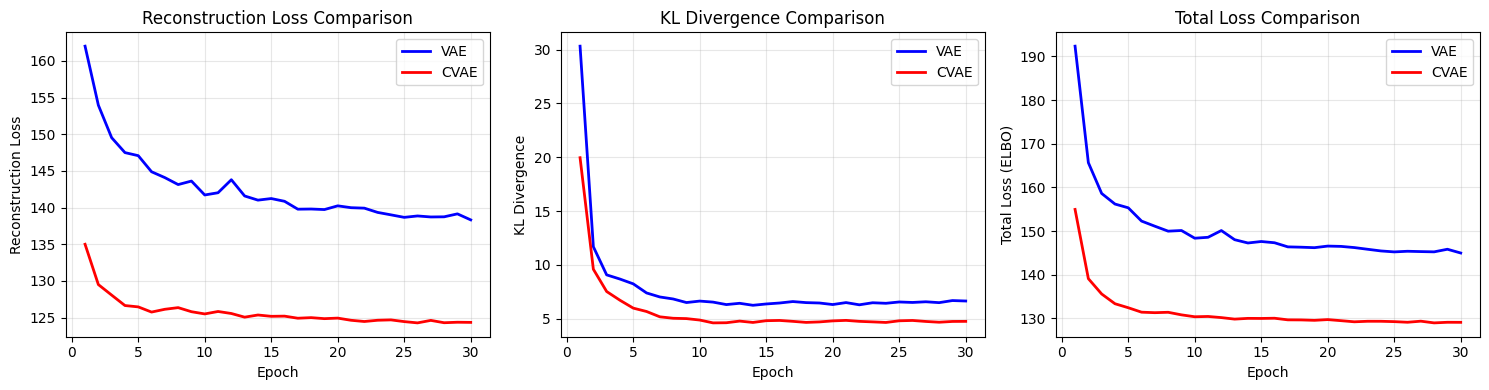

Saved figure to figures/vae_vs_cvae_comparison.png

MODEL COMPARISON SUMMARY
Metric                                VAE            CVAE
------------------------------------------------------------
Final Recon Loss                   138.32          124.34
Final KL Divergence                  6.66            4.76
Final Total Loss                   144.98          129.11


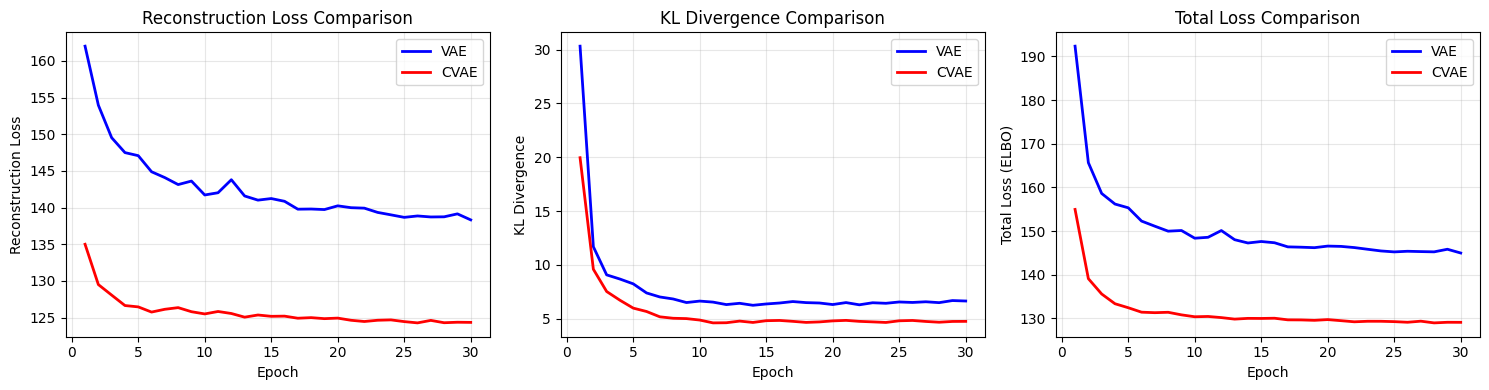

In [28]:
def save_and_show(fig, name, outdir='figures', dpi=150):
    import os
    os.makedirs(outdir, exist_ok=True)
    path = os.path.join(outdir, f"{name}.png")
    try:
        fig.savefig(path, bbox_inches='tight', dpi=dpi)
    except Exception as e:
        print("Warning: failed to save figure:", e)
    try:
        from IPython.display import display
        display(fig)
    except Exception:
        import matplotlib.pyplot as plt
        plt.show()
    print(f"Saved figure to {path}")

def compare_models(vae_history, cvae_history):
    """Compare VAE and CVAE training dynamics"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    epochs = range(1, len(vae_history['train_loss']) + 1)

    # Reconstruction loss comparison
    axes[0].plot(epochs, vae_history['test_recon'], 'b-', label='VAE', linewidth=2)
    axes[0].plot(epochs, cvae_history['test_recon'], 'r-', label='CVAE', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Reconstruction Loss')
    axes[0].set_title('Reconstruction Loss Comparison')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # KL comparison
    axes[1].plot(epochs, vae_history['test_kl'], 'b-', label='VAE', linewidth=2)
    axes[1].plot(epochs, cvae_history['test_kl'], 'r-', label='CVAE', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('KL Divergence')
    axes[1].set_title('KL Divergence Comparison')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Total loss comparison
    axes[2].plot(epochs, vae_history['test_loss'], 'b-', label='VAE', linewidth=2)
    axes[2].plot(epochs, cvae_history['test_loss'], 'r-', label='CVAE', linewidth=2)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Total Loss (ELBO)')
    axes[2].set_title('Total Loss Comparison')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

compare_fig = compare_models(history, cvae_history)
save_and_show(compare_fig, 'vae_vs_cvae_comparison')

# Print summary
print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(f"{'Metric':<25} {'VAE':>15} {'CVAE':>15}")
print("-"*60)
print(f"{'Final Recon Loss':<25} {history['test_recon'][-1]:>15.2f} {cvae_history['test_recon'][-1]:>15.2f}")
print(f"{'Final KL Divergence':<25} {history['test_kl'][-1]:>15.2f} {cvae_history['test_kl'][-1]:>15.2f}")
print(f"{'Final Total Loss':<25} {history['test_loss'][-1]:>15.2f} {cvae_history['test_loss'][-1]:>15.2f}")

### Remarks: Disentanglement Demonstration

**The three-row figure demonstrates CVAE's core capability:**

**Row 1 (Fixed z, interpolate → class=1):**
- Same style transfer: as z moves from "1-style" to "7-style", the output remains a "1"
- Shows that class conditioning overrides latent interpolation

**Row 2 (Fixed z, interpolate → class=7):**
- Same interpolation path but with class=7 conditioning
- The style variation is identical to row 1, but all outputs are "7"s

**Row 3 (Fixed z from digit 1, vary class 0-9):**
- One latent vector generates ALL 10 digit classes
- The writing style (slant, thickness) is preserved across classes
- This is **style transfer**: extract style from one image, apply to any class

**Theoretical connection:** This demonstrates the factorization $p(x|z,c)$ where:
- $z$ captures style/content (class-independent factors of variation)
- $c$ captures class identity

---
# Conclusion

## Summary

In this project, we:

1. **Derived the ELBO** from first principles, showing how it provides a tractable lower bound on the log-likelihood

2. **Explained the reparameterization trick** that enables gradient-based optimization through stochastic sampling

3. **Implemented a convolutional VAE** with proper architectural choices for MNIST

4. **Analyzed the KL vs Reconstruction trade-off**:
   - Under-regularization: High reconstruction, low KL → irregular latent space
   - Over-regularization: Low reconstruction, high KL → posterior collapse, blurry outputs
   - KL annealing helps balance these during training

5. **Visualized latent space structure** through:
   - 2D latent space scatter plots
   - Latent traversals showing what each dimension encodes
   - Interpolations demonstrating smooth transitions

6. **Extended to CVAE** for class-conditional generation:
   - Derived the conditional ELBO
   - Showed disentanglement of content (z) and class (c)
   - Demonstrated controlled generation

## Key Takeaways

- The **ELBO** elegantly balances reconstruction fidelity with latent space regularization
- **KL annealing** is crucial for stable training and avoiding posterior collapse
- **Conditioning** adds controllability without significantly changing the core VAE framework
- The **latent space structure** directly reflects what the model has learned